# NZ Aibnb Data Analysis

### Data preprocessing

In [111]:
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
from sklearn.model_selection import (train_test_split,StratifiedKFold,cross_val_score,cross_validate)
from sklearn.preprocessing import (StandardScaler,OneHotEncoder,LabelEncoder,PolynomialFeatures)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,GradientBoostingClassifier,HistGradientBoostingClassifier)
from sklearn.ensemble import (RandomForestRegressor,GradientBoostingRegressor)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.metrics import (roc_auc_score,average_precision_score,accuracy_score,f1_score,confusion_matrix,classification_report,log_loss,roc_curve,
precision_recall_curve,make_scorer)
from sklearn.inspection import permutation_importance
from sklearn import tree
from sklearn import tree as sktree

In [67]:
df = pd.read_csv('listings.csv', encoding='cp1252')
df.head()
d= df.copy()
print("Shape:", d.shape)
print("Columns:", len(d.columns))

Shape: (47097, 85)
Columns: 85


### Block processing

In [68]:
# Part 1: Build Feature Blocks (Branch A)
def detect_col(columns, candidates):
    lower = {c.lower(): c for c in columns}
    for cand in candidates:
        if cand.lower() in lower:
            return lower[cand.lower()]
    def norm(x): return re.sub(r"[\s_]+", "", str(x).lower())
    for c in columns:
        cn = norm(c)
        for cand in candidates:
            if norm(cand) in cn:
                return c
    return None

def percent_to_01(s):
    x = s.astype(str).str.strip().str.replace("%", "", regex=False)
    x = pd.to_numeric(x, errors="coerce")
    x = np.where(x > 1, x / 100.0, x)
    return pd.Series(x, index=s.index).astype(float)

def to_bool01(s):
    return (s.astype(str).str.strip().str.lower()
            .map({"t":1,"true":1,"1":1,"y":1,"yes":1,
                  "f":0,"false":0,"0":0,"n":0,"no":0})
            .astype(float))

def price_to_num(s):
    x = s.astype(str).str.strip().str.replace(r"[\$,]", "", regex=True)
    return pd.to_numeric(x, errors="coerce").astype(float)

# ---- target y ----
SUPER = detect_col(df.columns, ["host_is_superhost"])
if SUPER is None:
    raise ValueError("Cannot find host_is_superhost column.")

df = df.copy()
df["y_superhost"] = to_bool01(df[SUPER])
df = df[df["y_superhost"].notna()].copy()
df["y_superhost"] = df["y_superhost"].astype(int)
y = df["y_superhost"]

# ---- minimal derived fields used by blocks ----

# Response time -> ordinal (faster is smaller)
RSP_TIME = detect_col(df.columns, ["host_response_time"])
rsp_map = {"within an hour":0, "within a few hours":1, "within a day":2, "a few days or more":3}
if RSP_TIME and "host_response_time_ord" not in df.columns:
    df["host_response_time_ord"] = (df[RSP_TIME].astype(str).str.strip().str.lower().map(rsp_map))

# Response / acceptance rate -> numeric 0~1
RSP_RATE = detect_col(df.columns, ["host_response_rate"])
ACC_RATE = detect_col(df.columns, ["host_acceptance_rate"])
if RSP_RATE and "host_response_rate_num" not in df.columns:
    df["host_response_rate_num"] = percent_to_01(df[RSP_RATE])
if ACC_RATE and "host_acceptance_rate_num" not in df.columns:
    df["host_acceptance_rate_num"] = percent_to_01(df[ACC_RATE])

# Instant bookable -> 0/1
INSTANT = detect_col(df.columns, ["instant_bookable"])
if INSTANT and "instant_bookable_01" not in df.columns:
    df["instant_bookable_01"] = to_bool01(df[INSTANT]).fillna(0).astype(int)

# last_review -> days_since_last_review
SCRAPED = detect_col(df.columns, ["last_scraped"])
LAST_REVIEW = detect_col(df.columns, ["last_review"])
snap = pd.to_datetime(df[SCRAPED], errors="coerce") if SCRAPED else pd.Timestamp.today().normalize()
if LAST_REVIEW:
    lr = pd.to_datetime(df[LAST_REVIEW], errors="coerce")
    df["days_since_last_review"] = (snap - lr).dt.days

# price -> numeric + log
PRICE = detect_col(df.columns, ["price"])
if PRICE and "price_num" not in df.columns:
    df["price_num"] = price_to_num(df[PRICE])
df["log_price"] = np.log1p(df["price_num"]) if "price_num" in df.columns else np.nan

# bathrooms_text -> numeric (optional)
BATH_TXT = detect_col(df.columns, ["bathrooms_text"])
if BATH_TXT and "bathrooms_num" not in df.columns:
    df["bathrooms_num"] = pd.to_numeric(df[BATH_TXT].astype(str).str.extract(r"(\d+(\.\d+)?)")[0],
                                        errors="coerce")

# ---- Block A: Host Response ----
cols_A = [c for c in ["host_response_rate_num", "host_response_time_ord",
                      "host_acceptance_rate_num", "instant_bookable_01"]
          if c in df.columns]
X_A = df[cols_A]

# ---- Block B: Ratings (review_scores_*) ----
cols_B = [c for c in df.columns if c.startswith("review_scores_")]
X_B = df[cols_B] if cols_B else pd.DataFrame(index=df.index)

# ---- Block C: Review Activity ----
cols_C = [c for c in ["number_of_reviews", "reviews_per_month",
                      "number_of_reviews_ltm", "number_of_reviews_l30d",
                      "days_since_last_review"]
          if c in df.columns]
X_C = df[cols_C]

# ---- Block D: Listing Structure (type/capacity/price/location) ----
PROP = detect_col(df.columns, ["property_type"])
ROOM = detect_col(df.columns, ["room_type"])
LOC1 = detect_col(df.columns, ["region_name", "region_parent_name"])
LOC2 = detect_col(df.columns, ["neighbourhood", "neighborhood"])
# choose one or two location columns
loc_cols = [c for c in [LOC1, LOC2] if c is not None]

num_D = [c for c in ["accommodates", "bedrooms", "beds", "bathrooms_num",
                     "minimum_nights", "log_price"]
         if c in df.columns]
cat_D = [c for c in [PROP, ROOM] if c is not None] + loc_cols
cols_D = num_D + cat_D
X_D = df[cols_D]

# ---- pack blocks ----
blocks = {
    "A_response": {"X": X_A, "y": y, "cols": cols_A},
    "B_ratings":  {"X": X_B, "y": y, "cols": cols_B},
    "C_activity": {"X": X_C, "y": y, "cols": cols_C},
    "D_listing":  {"X": X_D, "y": y, "cols": cols_D},
}

# quick check
for k, v in blocks.items():
    print(f"{k}: X shape={v['X'].shape}, cols={len(v['cols'])}")
print("label superhost rate:", y.mean())

A_response: X shape=(45991, 4), cols=4
B_ratings: X shape=(45991, 7), cols=7
C_activity: X shape=(45991, 5), cols=5
D_listing: X shape=(45991, 10), cols=10
label superhost rate: 0.4803331086516927


### Block A response_Logistic regression

In [167]:
# X, y (Block A)
X = blocks["A_response"]["X"].copy()
y = blocks["A_response"]["y"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)

X.shape, y.mean()

#Model pipeline
clf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=3000, class_weight="balanced"))
])

clf

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=3000))])

In [168]:
clf.fit(X_train, y_train)

test_prob = clf.predict_proba(X_test)[:, 1]
test_pred = (test_prob >= 0.5).astype(int)

train_prob = clf.predict_proba(X_train)[:, 1]
train_pred = (train_prob >= 0.5).astype(int)

def print_evaluate(y_true, y_prob, y_pred, name=""):
    auc = metrics.roc_auc_score(y_true, y_prob)
    ap  = metrics.average_precision_score(y_true, y_prob)  # PR-AUC
    acc = metrics.accuracy_score(y_true, y_pred)
    f1  = metrics.f1_score(y_true, y_pred)

    if name:
        print(name)

    print(f"AUC      : {auc:.4f}")
    print(f"PR-AUC   : {ap:.4f}")
    print(f"Accuracy : {acc:.4f}")
    print(f"F1       : {f1:.4f}")
    print("\nConfusion matrix:\n", metrics.confusion_matrix(y_true, y_pred))
    print("\nClassification report:\n", metrics.classification_report(y_true, y_pred, digits=4))

print_evaluate(y_test, test_prob, test_pred, "Test set evaluation")
print("\n" + "-"*40 + "\n")
print_evaluate(y_train, train_prob, train_pred, "Train set evaluation")

Test set evaluation
AUC      : 0.6228
PR-AUC   : 0.5447
Accuracy : 0.5934
F1       : 0.6697

Confusion matrix:
 [[2501 4669]
 [ 941 5687]]

Classification report:
               precision    recall  f1-score   support

           0     0.7266    0.3488    0.4714      7170
           1     0.5492    0.8580    0.6697      6628

    accuracy                         0.5934     13798
   macro avg     0.6379    0.6034    0.5705     13798
weighted avg     0.6414    0.5934    0.5666     13798


----------------------------------------

Train set evaluation
AUC      : 0.6200
PR-AUC   : 0.5430
Accuracy : 0.5923
F1       : 0.6689

Confusion matrix:
 [[ 5812 10918]
 [ 2207 13256]]

Classification report:
               precision    recall  f1-score   support

           0     0.7248    0.3474    0.4697     16730
           1     0.5484    0.8573    0.6689     15463

    accuracy                         0.5923     32193
   macro avg     0.6366    0.6023    0.5693     32193
weighted avg     0.6400  

In [169]:
#Cross validation (AUC)

from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_auc = cross_val_score(clf, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_acc = cross_val_score(clf, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
cv_f1  = cross_val_score(clf, X, y, cv=cv, scoring="f1", n_jobs=-1)

print("CV AUC (5-fold):", cv_auc.mean(), "±", cv_auc.std())
print("CV ACC (5-fold):", cv_acc.mean(), "±", cv_acc.std())
print("CV F1  (5-fold):", cv_f1.mean(),  "±", cv_f1.std())
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc = cross_val_score(clf, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)

print("CV AUC (5-fold):", cv_auc)
print("Mean CV AUC    :", cv_auc.mean())

# Coefficients table
# Positive coef -> higher P(superhost)

coef = clf.named_steps["clf"].coef_.ravel()
coef_df = pd.DataFrame({"Feature": X.columns, "Coefficient": coef}).sort_values(
    "Coefficient", ascending=False
)
coef_df



CV AUC (5-fold): 0.6203431736472125 ± 0.003951157389057298
CV ACC (5-fold): 0.5917462146979353 ± 0.003524069281052717
CV F1  (5-fold): 0.6677227199171992 ± 0.0012524838578465676
CV AUC (5-fold): [0.61856192 0.6151435  0.62531409 0.61809867 0.62459769]
Mean CV AUC    : 0.6203431736472125


Feature  Coefficient
2  host_acceptance_rate_num     0.844059
0    host_response_rate_num     0.300030
1    host_response_time_ord    -0.092875
3       instant_bookable_01    -0.148768

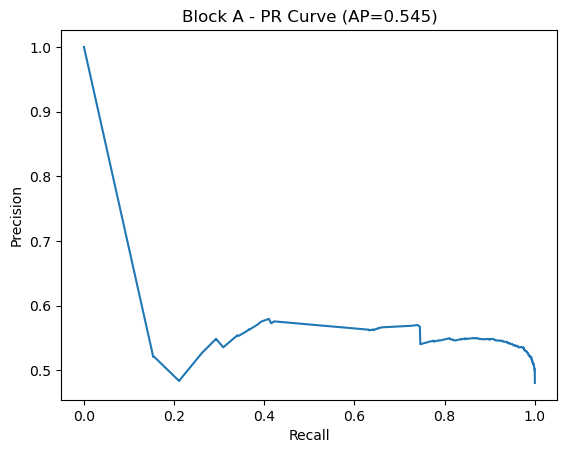

In [170]:
p, r, _ = precision_recall_curve(y_test, test_prob)
ap = average_precision_score(y_test, test_prob)

plt.figure()
plt.plot(r, p)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Block A - PR Curve (AP={ap:.3f})")
plt.show()

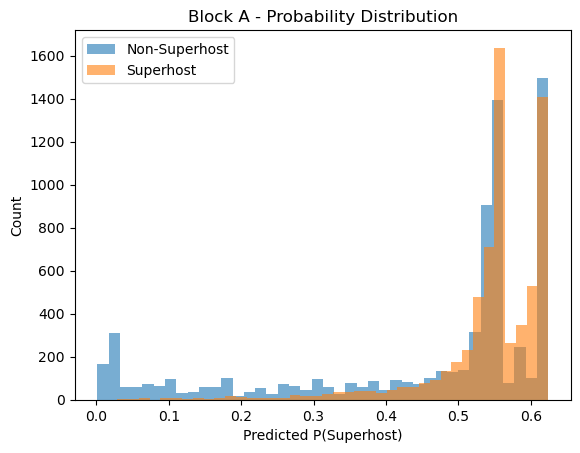

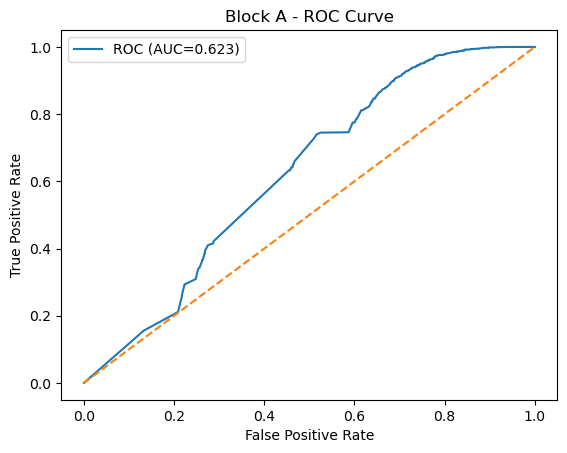

In [171]:
#Plots Probability distribution
plt.figure()
plt.hist(test_prob[y_test == 0], bins=40, alpha=0.6, label="Non-Superhost")
plt.hist(test_prob[y_test == 1], bins=40, alpha=0.6, label="Superhost")
plt.xlabel("Predicted P(Superhost)")
plt.ylabel("Count")
plt.legend()
plt.title("Block A - Probability Distribution")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, test_prob)
auc = roc_auc_score(y_test, test_prob)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Block A - ROC Curve")
plt.legend()
plt.show()

### Block A polynomial features with Logistic

In [172]:
clf_poly = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),  
    ("scaler", StandardScaler(with_mean=False)),  # poly feature 
    ("clf", LogisticRegression(max_iter=5000, class_weight="balanced"))
])

clf_poly.fit(X_train, y_train)
prob = clf_poly.predict_proba(X_test)[:, 1]
pred = (prob >= 0.5).astype(int)

# --- metrics ---
auc = metrics.roc_auc_score(y_test, prob)
ap  = metrics.average_precision_score(y_test, prob)   # PR-AUC
acc = metrics.accuracy_score(y_test, pred)
f1  = metrics.f1_score(y_test, pred)

print(f"AUC      : {auc:.4f}")
print(f"PR-AUC   : {ap:.4f}")
print(f"Accuracy : {acc:.4f}")
print(f"F1       : {f1:.4f}")
print("\nConfusion matrix:\n", metrics.confusion_matrix(y_test, pred))
print("\nClassification report:\n", metrics.classification_report(y_test, pred, digits=4))

AUC      : 0.6763
PR-AUC   : 0.6252
Accuracy : 0.6259
F1       : 0.7001

Confusion matrix:
 [[2611 4559]
 [ 603 6025]]

Classification report:
               precision    recall  f1-score   support

           0     0.8124    0.3642    0.5029      7170
           1     0.5693    0.9090    0.7001      6628

    accuracy                         0.6259     13798
   macro avg     0.6908    0.6366    0.6015     13798
weighted avg     0.6956    0.6259    0.5976     13798



### Block A RandomForestClassifier

In [173]:
# X, y (Block A)
X = blocks["A_response"]["X"].copy()
y = blocks["A_response"]["y"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)

rf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(
        n_estimators=500, random_state=42,
        class_weight="balanced_subsample",
        n_jobs=-1
    ))
])

rf.fit(X_train, y_train)

imp = pd.Series(rf.named_steps["clf"].feature_importances_, index=X.columns).sort_values(ascending=False)
imp

host_acceptance_rate_num    0.641911
host_response_rate_num      0.257408
host_response_time_ord      0.068767
instant_bookable_01         0.031914
dtype: float64

In [174]:
# X, y (Block A)
X = blocks["A_response"]["X"].copy()
y = blocks["A_response"]["y"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)

r = permutation_importance(
    clf_poly, X_test, y_test,
    n_repeats=10, random_state=42, scoring="roc_auc"
)

imp = pd.Series(r.importances_mean, index=X.columns).sort_values(ascending=False)
imp

host_acceptance_rate_num    0.114756
host_response_rate_num      0.029046
host_response_time_ord      0.014754
instant_bookable_01         0.013742
dtype: float64

In [175]:
from sklearn.metrics import get_scorer_names
get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'd2_absolute_error_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_max_error',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'neg_root_mean_squared_log_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 're

### Block A Gradient boost

In [211]:
# X, y (Block A)
X = blocks["A_response"]["X"].copy()
y = blocks["A_response"]["y"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)

def run_gb_block_exact(X_train, y_train, X_test, y_test, X_full, y_full,
                       model_name="GradientBoostingClassifier",
                       params=None, cv=5, threshold=0.5):
    if params is None:
        params = {
            "n_estimators": 500,
            "max_depth": 3,
            "learning_rate": 0.05,
            "subsample": 0.8,
            "random_state": 42
        }

    gb_clf = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", GradientBoostingClassifier(**params))
    ])

    # fit
    gb_clf.fit(X_train, y_train)

    # predict (test/train)
    test_prob  = gb_clf.predict_proba(X_test)[:, 1]
    test_pred  = (test_prob >= threshold).astype(int)

    train_prob = gb_clf.predict_proba(X_train)[:, 1]
    train_pred = (train_prob >= threshold).astype(int)

    #block 1: confusion + report
    print("Confusion matrix:")
    print(metrics.confusion_matrix(y_test, test_pred))

    print("\nClassification report:")
    print(metrics.classification_report(y_test, test_pred, digits=4))

    # metric helper
    def scores(y_true, prob, pred):
        auc = metrics.roc_auc_score(y_true, prob)
        ap  = metrics.average_precision_score(y_true, prob)
        acc = metrics.accuracy_score(y_true, pred)
        f1  = metrics.f1_score(y_true, pred)
        return auc, ap, acc, f1

    #block 2: test evaluation
    auc_t, ap_t, acc_t, f1_t = scores(y_test, test_prob, test_pred)
    print("\nTest set evaluation:")
    print(f"AUC      : {auc_t}")
    print(f"PR-AUC   : {ap_t}")
    print(f"Accuracy : {acc_t}")
    print(f"F1       : {f1_t}")

    #block 3: train evaluation
    auc_tr, ap_tr, acc_tr, f1_tr = scores(y_train, train_prob, train_pred)
    print("\nTrain set evaluation:")
    print(f"AUC      : {auc_tr}")
    print(f"PR-AUC   : {ap_tr}")
    print(f"Accuracy : {acc_tr}")
    print(f"F1       : {f1_tr}")

    #block 4: CV + evaluate_df
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    cv_list = cross_val_score(gb_clf, X_full, y_full, cv=skf, scoring="roc_auc", n_jobs=-1)

    evaluate_df = pd.DataFrame(
        data=[[
            model_name,
            auc_t, ap_t, acc_t, f1_t,
            cv_list
        ]],
        columns=["Model", "AUC", "PR-AUC", "Accuracy", "F1", "Cross Validation (AUC)"]
    )

    return gb_clf, evaluate_df

gb_model, evaluate_df_gb = run_gb_block_exact(
    X_train, y_train, X_test, y_test,
    X, y,
    model_name="GradientBoostingClassifier",
    cv=5,
    threshold=0.5
)

evaluate_df_gb

Confusion matrix:
[[3739 3431]
 [1131 5497]]

Classification report:
              precision    recall  f1-score   support

           0     0.7678    0.5215    0.6211      7170
           1     0.6157    0.8294    0.7067      6628

    accuracy                         0.6694     13798
   macro avg     0.6917    0.6754    0.6639     13798
weighted avg     0.6947    0.6694    0.6622     13798


Test set evaluation:
AUC      : 0.7507538387921913
PR-AUC   : 0.7024097612041778
Accuracy : 0.6693723728076533
F1       : 0.7067369503728465

Train set evaluation:
AUC      : 0.7547442579222043
PR-AUC   : 0.7037423586631737
Accuracy : 0.6733451371416146
F1       : 0.7095829881248273


Model       AUC   PR-AUC  Accuracy        F1  \
0  GradientBoostingClassifier  0.750754  0.70241  0.669372  0.706737   

                              Cross Validation (AUC)  
0  [0.7528778591116149, 0.7452914190900292, 0.755...

In [212]:
imp = pd.Series(
    gb_model.named_steps["clf"].feature_importances_,
    index=X.columns
).sort_values(ascending=False)

imp

host_acceptance_rate_num    0.684466
host_response_rate_num      0.239004
host_response_time_ord      0.046020
instant_bookable_01         0.030510
dtype: float64

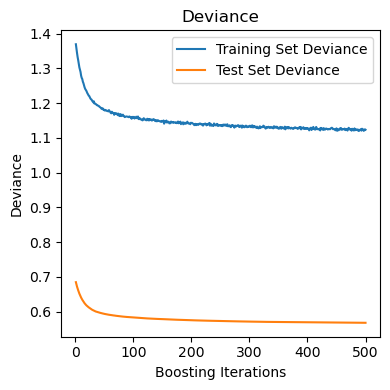

In [178]:
imputer = gb_model.named_steps["imputer"]
gb_clf  = gb_model.named_steps["clf"]

# Transform X (pipeline preprocessing)
Xtr = imputer.transform(X_train)
Xte = imputer.transform(X_test)

# Compute deviance (log loss) per stage
n_est = gb_clf.n_estimators

test_score = np.zeros(n_est, dtype=np.float64)

# staged_predict_proba yields proba for each stage
for i, proba in enumerate(gb_clf.staged_predict_proba(Xte)):
    test_score[i] = log_loss(y_test, proba, labels=gb_clf.classes_)

# Plot
plt.figure(figsize=(4, 4))
plt.title("Deviance")
plt.plot(np.arange(n_est) + 1, gb_clf.train_score_, label="Training Set Deviance")
plt.plot(np.arange(n_est) + 1, test_score, label="Test Set Deviance")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

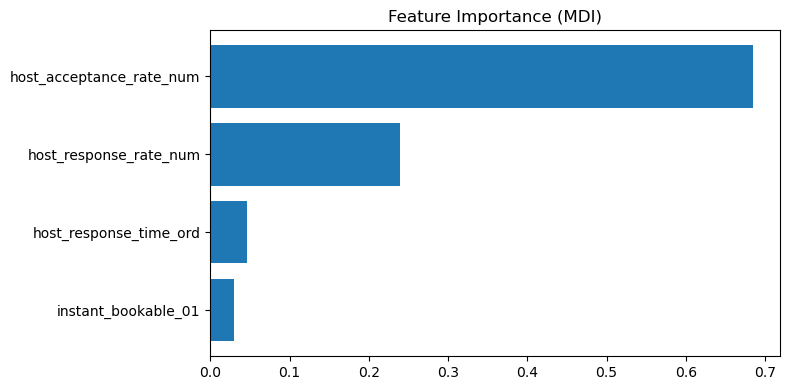

In [179]:
gb_est = gb_model.named_steps["clf"]

feature_importance = gb_est.feature_importances_
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + 0.5

plt.figure(figsize=(8, 4))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, X.columns.to_numpy()[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.tight_layout()
plt.show()

### Block A Decision Tree

In [224]:
# X, y (Block A)
X = blocks["A_response"]["X"].copy().apply(pd.to_numeric, errors="coerce")
y = blocks["A_response"]["y"].copy().astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=15, stratify=y
)


dtc = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=200,
    class_weight="balanced",
    random_state=42
)
dtc.fit(X_train, y_train)

pred = dtc.predict(X_test)
prob = dtc.predict_proba(X_test)[:, 1]

In [225]:
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score, classification_report, confusion_matrix

print("Confusion matrix:\n", confusion_matrix(y_test, pred))
print("\nClassification report:\n", classification_report(y_test, pred, digits=4))

print("\nAUC     :", roc_auc_score(y_test, prob))
print("PR-AUC  :", average_precision_score(y_test, prob))
print("Accuracy:", accuracy_score(y_test, pred))
print("F1      :", f1_score(y_test, pred))

Confusion matrix:
 [[4348 2822]
 [ 943 5685]]

Classification report:
               precision    recall  f1-score   support

           0     0.8218    0.6064    0.6979      7170
           1     0.6683    0.8577    0.7512      6628

    accuracy                         0.7271     13798
   macro avg     0.7450    0.7321    0.7245     13798
weighted avg     0.7480    0.7271    0.7235     13798


AUC     : 0.7881167465862672
PR-AUC  : 0.7051619395188513
Accuracy: 0.7271343672996087
F1      : 0.7512388503468781


In [232]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)

prob = dtc.predict_proba(X_test)[:, 1]   
pred = (prob >= 0.5).astype(int)

print_evaluate(y_test, prob, pred, name="DecisionTree (test)")

DecisionTree (test)
AUC      : 0.8106
PR-AUC   : 0.7383
Accuracy : 0.7434
F1       : 0.7673

Confusion matrix:
 [[4422 2748]
 [ 792 5836]]

Classification report:
               precision    recall  f1-score   support

           0     0.8481    0.6167    0.7141      7170
           1     0.6799    0.8805    0.7673      6628

    accuracy                         0.7434     13798
   macro avg     0.7640    0.7486    0.7407     13798
weighted avg     0.7673    0.7434    0.7397     13798



In [230]:
importance = pd.Series(dtc.feature_importances_, index=X.columns).sort_values(ascending=False)
importance

host_response_rate_num      0.520073
host_acceptance_rate_num    0.407196
host_response_time_ord      0.055582
instant_bookable_01         0.017149
dtype: float64

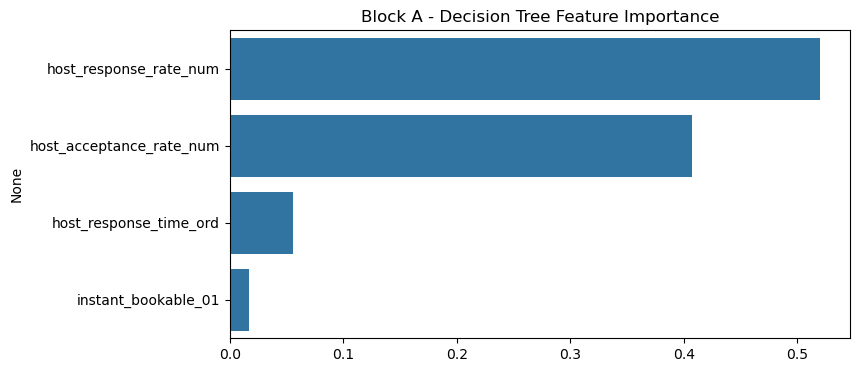

In [231]:
plt.figure(figsize=(8,4))
sns.barplot(x=importance.values, y=importance.index)
plt.title("Block A - Decision Tree Feature Importance")
plt.show()

[Text(0.507886380272837, 0.9772727272727273, 'x[0] <= 0.985\ngini = 0.499\nsamples = 32193\nvalue = [16730, 15463]'),
 Text(0.20985680030481293, 0.9318181818181818, 'x[2] <= 0.675\ngini = 0.249\nsamples = 8309\nvalue = [7096, 1213]'),
 Text(0.3588715902888249, 0.9545454545454546, 'True  '),
 Text(0.0503395114451657, 0.8863636363636364, 'x[0] <= 0.895\ngini = 0.028\nsamples = 3353\nvalue = [3306, 47]'),
 Text(0.026883327639221046, 0.8409090909090909, 'x[2] <= 0.565\ngini = 0.02\nsamples = 3301\nvalue = [3268, 33]'),
 Text(0.01093269559275709, 0.7954545454545454, 'x[2] <= 0.325\ngini = 0.01\nsamples = 3009\nvalue = [2994, 15]'),
 Text(0.009566108643662453, 0.75, 'gini = 0.0\nsamples = 860\nvalue = [860, 0]'),
 Text(0.012299282541851725, 0.75, 'x[2] <= 0.365\ngini = 0.014\nsamples = 2149\nvalue = [2134, 15]'),
 Text(0.005466347796378545, 0.7045454545454546, 'x[2] <= 0.355\ngini = 0.056\nsamples = 105\nvalue = [102, 3]'),
 Text(0.0027331738981892723, 0.6590909090909091, 'x[0] <= inf\ngini 

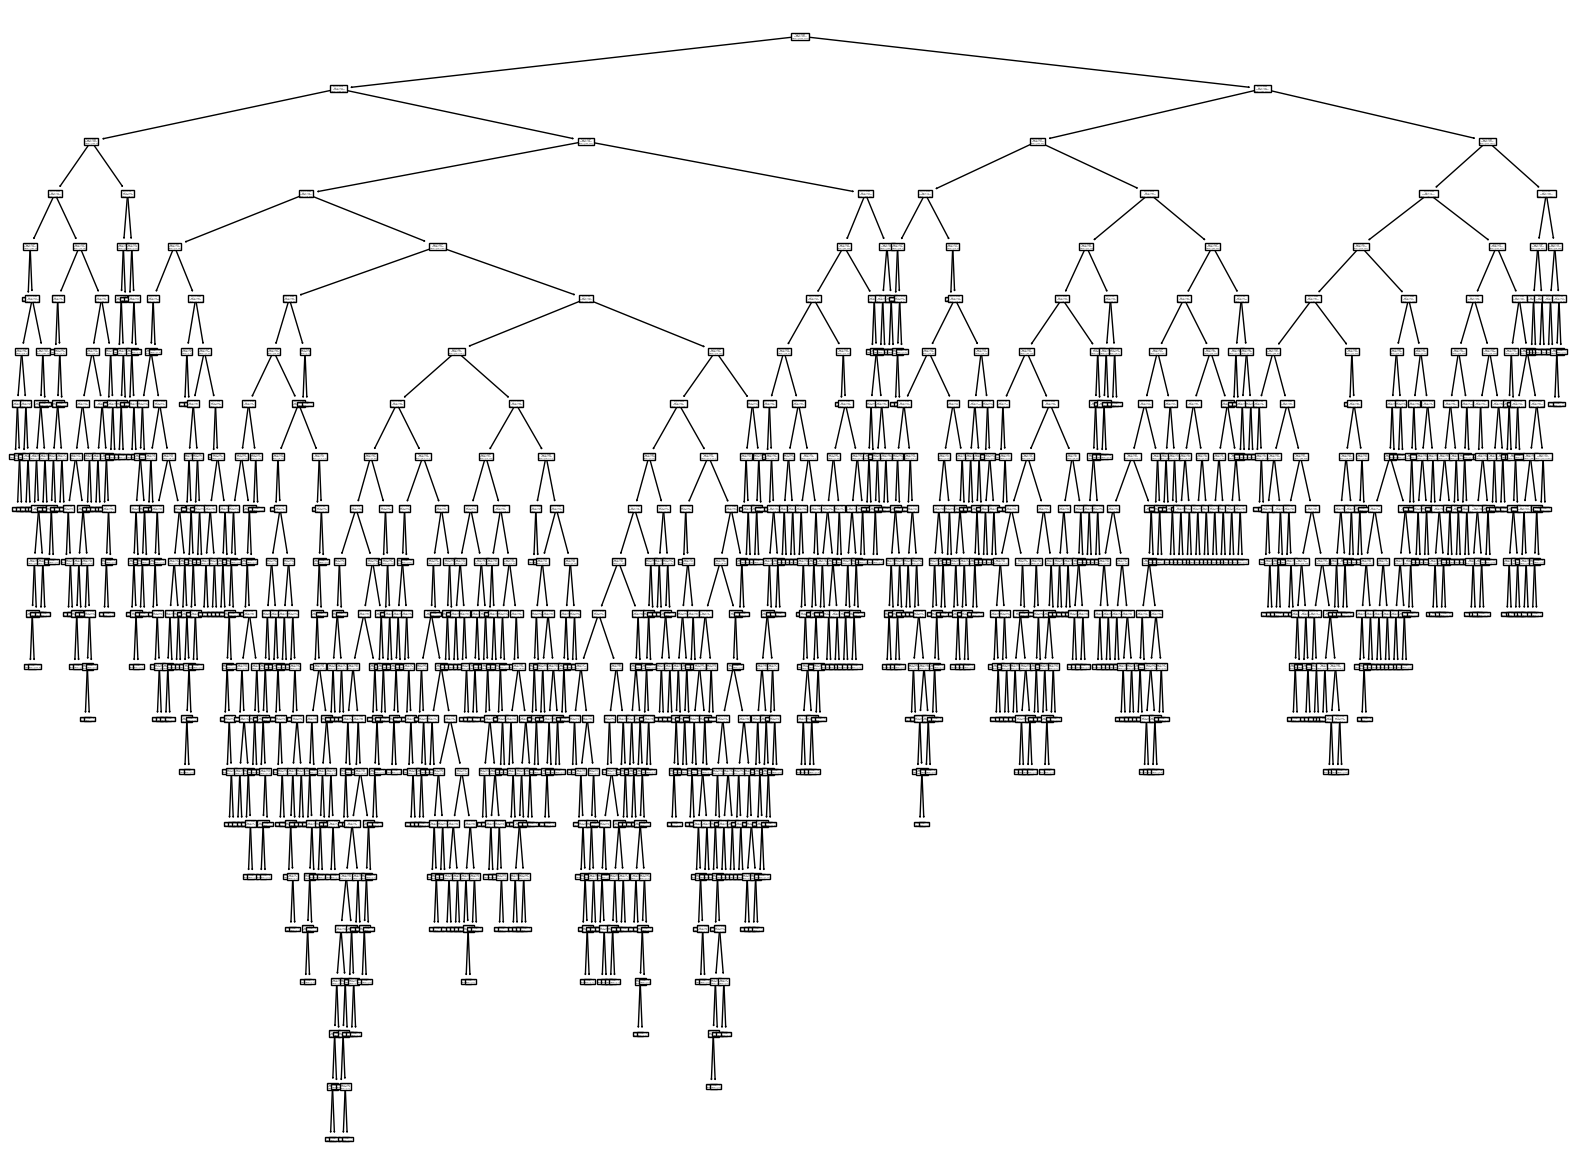

In [233]:
from sklearn import tree
plt.rcParams['figure.figsize'] = [20, 15]
tree.plot_tree(dtc) 

### Block A K-means

In [192]:
X = blocks["A_response"]["X"].copy()
y = blocks["A_response"]["y"].copy()

feat4 = ["host_response_rate_num", "host_response_time_ord",
         "host_acceptance_rate_num", "instant_bookable_01"]

X4 = X[feat4].apply(pd.to_numeric, errors="coerce")
X4 = X4.fillna(X4.median(numeric_only=True))

X4s = StandardScaler().fit_transform(X4)

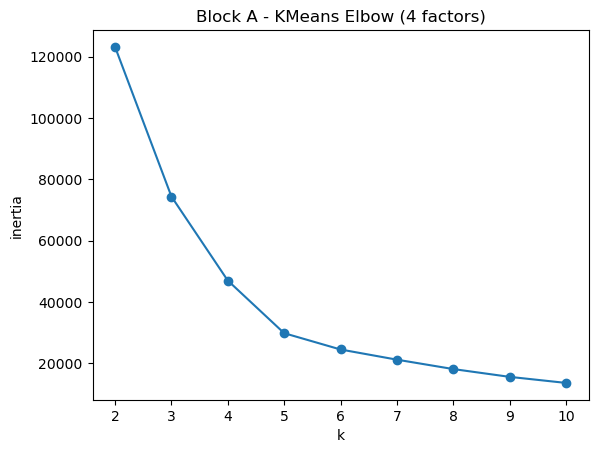

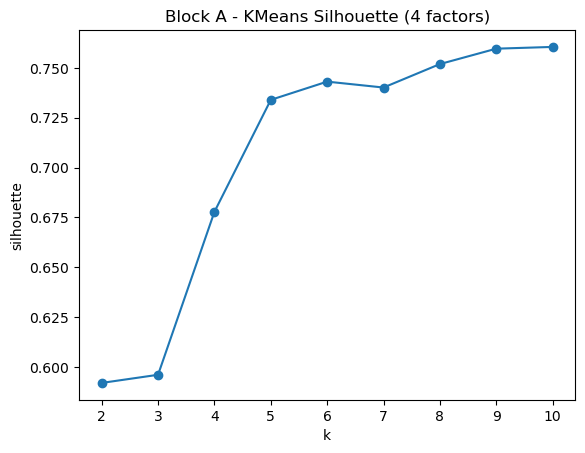

In [193]:
Ks = range(2, 11)
inertias, sils = [], []

for k in Ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X4s)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X4s, labels, sample_size=5000, random_state=42))

plt.figure()
plt.plot(list(Ks), inertias, marker="o")
plt.xlabel("k"); plt.ylabel("inertia")
plt.title("Block A - KMeans Elbow (4 factors)")
plt.show()

plt.figure()
plt.plot(list(Ks), sils, marker="o")
plt.xlabel("k"); plt.ylabel("silhouette")
plt.title("Block A - KMeans Silhouette (4 factors)")
plt.show()

count  superhost_rate
cluster_id                       
0           17637        0.507513
1           21225        0.554299
2            1062        0.060264
3            6067        0.216087

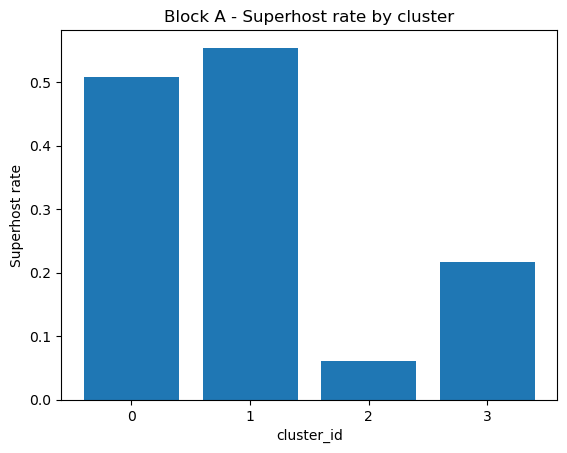

In [194]:
k_final = 4
kmeans = KMeans(n_clusters=k_final, n_init=20, random_state=42)
cluster_id = kmeans.fit_predict(X4s)

tmp = X4.copy()
tmp["cluster_id"] = cluster_id
tmp["is_superhost"] = y.values

# 1) Superhost rate by cluster
rate = tmp.groupby("cluster_id")["is_superhost"].agg(count="size", superhost_rate="mean").sort_index()
display(rate)

plt.figure()
plt.bar(rate.index.astype(str), rate["superhost_rate"].values)
plt.xlabel("cluster_id")
plt.ylabel("Superhost rate")
plt.title("Block A - Superhost rate by cluster")
plt.show()

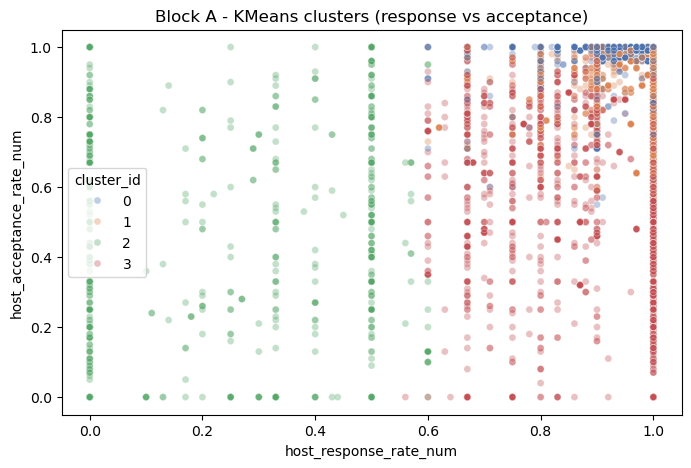

In [197]:
tmp = X.copy()
tmp["cluster_id"] = cluster_id

plt.figure(figsize=(8,5))
sns.scatterplot(
    data=tmp,
    x="host_response_rate_num",
    y="host_acceptance_rate_num",
    hue="cluster_id",
    palette="deep",      
    alpha=0.35, s=25
)
plt.title("Block A - KMeans clusters (response vs acceptance)")
plt.show()

### Block B_review rate-Logistic regression

In [5]:
# X, y (Block B)
X = blocks["B_ratings"]["X"].copy()
y = blocks["B_ratings"]["y"].copy()

if X.shape[1] == 0:
    raise ValueError("Block B has no review_scores_* columns. Check cols_B creation.")

X = X.apply(pd.to_numeric, errors="coerce")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)
X.shape, y.mean()

#Model pipeline
clf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=3000, class_weight="balanced"))
])

clf

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=3000))])

In [6]:
clf.fit(X_train, y_train)

test_prob = clf.predict_proba(X_test)[:, 1]
test_pred = (test_prob >= 0.5).astype(int)

train_prob = clf.predict_proba(X_train)[:, 1]
train_pred = (train_prob >= 0.5).astype(int)

def print_evaluate(y_true, y_prob, y_pred, name=""):
    auc = metrics.roc_auc_score(y_true, y_prob)
    ap  = metrics.average_precision_score(y_true, y_prob)  # PR-AUC
    acc = metrics.accuracy_score(y_true, y_pred)
    f1  = metrics.f1_score(y_true, y_pred)

    if name:
        print(name)

    print(f"AUC      : {auc:.4f}")
    print(f"PR-AUC   : {ap:.4f}")
    print(f"Accuracy : {acc:.4f}")
    print(f"F1       : {f1:.4f}")
    print("\nConfusion matrix:\n", metrics.confusion_matrix(y_true, y_pred))
    print("\nClassification report:\n", metrics.classification_report(y_true, y_pred, digits=4))

print_evaluate(y_test, test_prob, test_pred, "Test set evaluation")
print("\n" + "-"*40 + "\n")
print_evaluate(y_train, train_prob, train_pred, "Train set evaluation")

Test set evaluation
AUC      : 0.5850
PR-AUC   : 0.5036
Accuracy : 0.5658
F1       : 0.6209

Confusion matrix:
 [[2901 4269]
 [1722 4906]]

Classification report:
               precision    recall  f1-score   support

           0     0.6275    0.4046    0.4920      7170
           1     0.5347    0.7402    0.6209      6628

    accuracy                         0.5658     13798
   macro avg     0.5811    0.5724    0.5564     13798
weighted avg     0.5829    0.5658    0.5539     13798


----------------------------------------

Train set evaluation
AUC      : 0.5938
PR-AUC   : 0.5106
Accuracy : 0.5685
F1       : 0.6243

Confusion matrix:
 [[ 6761  9969]
 [ 3923 11540]]

Classification report:
               precision    recall  f1-score   support

           0     0.6328    0.4041    0.4933     16730
           1     0.5365    0.7463    0.6243     15463

    accuracy                         0.5685     32193
   macro avg     0.5847    0.5752    0.5588     32193
weighted avg     0.5866  

In [7]:
#Cross validation (AUC)

from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_auc = cross_val_score(clf, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_acc = cross_val_score(clf, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
cv_f1  = cross_val_score(clf, X, y, cv=cv, scoring="f1", n_jobs=-1)

print("CV AUC (5-fold):", cv_auc.mean(), "±", cv_auc.std())
print("CV ACC (5-fold):", cv_acc.mean(), "±", cv_acc.std())
print("CV F1  (5-fold):", cv_f1.mean(),  "±", cv_f1.std())
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc = cross_val_score(clf, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)

print("CV AUC (5-fold):", cv_auc)
print("Mean CV AUC    :", cv_auc.mean())

# Coefficients table
# Positive coef -> higher P(superhost)

coef = clf.named_steps["clf"].coef_.ravel()
coef_df = pd.DataFrame({"Feature": X.columns, "Coefficient": coef}).sort_values(
    "Coefficient", ascending=False
)
coef_df

CV AUC (5-fold): 0.591798928714047 ± 0.00556873384072419
CV ACC (5-fold): 0.5688720785872501 ± 0.00477085750225749
CV F1  (5-fold): 0.6241540843462037 ± 0.00522694593676734
CV AUC (5-fold): [0.59409148 0.59309884 0.59515478 0.59583167 0.58081787]
Mean CV AUC    : 0.591798928714047


Feature  Coefficient
2    review_scores_cleanliness     0.291862
0         review_scores_rating     0.243531
6          review_scores_value     0.122763
4  review_scores_communication     0.110608
3        review_scores_checkin     0.031534
1       review_scores_accuracy     0.029963
5       review_scores_location    -0.066113

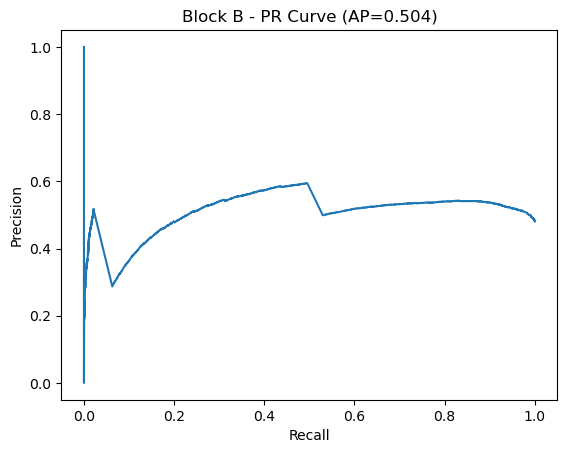

In [8]:
p, r, _ = precision_recall_curve(y_test, test_prob)
ap = average_precision_score(y_test, test_prob)

plt.figure()
plt.plot(r, p)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Block B - PR Curve (AP={ap:.3f})")
plt.show()

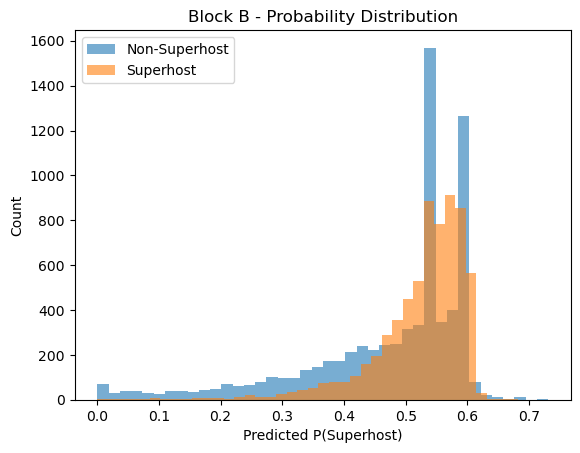

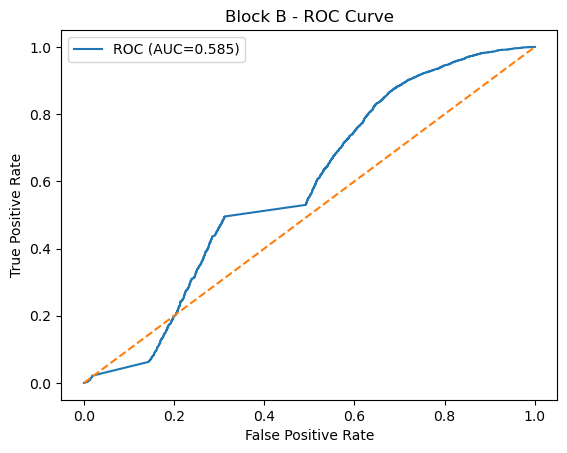

In [9]:
#Plots Probability distribution
plt.figure()
plt.hist(test_prob[y_test == 0], bins=40, alpha=0.6, label="Non-Superhost")
plt.hist(test_prob[y_test == 1], bins=40, alpha=0.6, label="Superhost")
plt.xlabel("Predicted P(Superhost)")
plt.ylabel("Count")
plt.legend()
plt.title("Block B - Probability Distribution")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, test_prob)
auc = roc_auc_score(y_test, test_prob)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Block B - ROC Curve")
plt.legend()
plt.show()

### Block B polynomial features with Logistic

In [10]:
# ---- fixed X, y once ----
X = blocks["B_ratings"]["X"].copy().apply(pd.to_numeric, errors="coerce")
y = blocks["B_ratings"]["y"].copy().astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=0, stratify=y
)


clf_poly = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),  
    ("scaler", StandardScaler(with_mean=False)),  # poly feature 
    ("clf", LogisticRegression(max_iter=5000, class_weight="balanced"))
])

clf_poly.fit(X_train, y_train)
prob = clf_poly.predict_proba(X_test)[:, 1]
pred = (prob >= 0.5).astype(int)

# --- metrics ---
auc = metrics.roc_auc_score(y_test, prob)
ap  = metrics.average_precision_score(y_test, prob)   # PR-AUC
acc = metrics.accuracy_score(y_test, pred)
f1  = metrics.f1_score(y_test, pred)

print(f"AUC      : {auc:.4f}")
print(f"PR-AUC   : {ap:.4f}")
print(f"Accuracy : {acc:.4f}")
print(f"F1       : {f1:.4f}")
print("\nConfusion matrix:\n", metrics.confusion_matrix(y_test, pred))
print("\nClassification report:\n", metrics.classification_report(y_test, pred, digits=4))

AUC      : 0.6044
PR-AUC   : 0.5420
Accuracy : 0.5804
F1       : 0.6357

Confusion matrix:
 [[2959 4211]
 [1578 5050]]

Classification report:
               precision    recall  f1-score   support

           0     0.6522    0.4127    0.5055      7170
           1     0.5453    0.7619    0.6357      6628

    accuracy                         0.5804     13798
   macro avg     0.5987    0.5873    0.5706     13798
weighted avg     0.6008    0.5804    0.5680     13798



### Block B RandomForestClassifier

In [11]:
X = blocks["B_ratings"]["X"].copy().apply(pd.to_numeric, errors="coerce")
y = blocks["B_ratings"]["y"].copy().astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=0, stratify=y
)

rf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(
        n_estimators=500, random_state=42,
        class_weight="balanced_subsample",
        n_jobs=-1
    ))
])

rf.fit(X_train, y_train)

imp = (pd.Series(rf.named_steps["clf"].feature_importances_, index=X.columns)
         .sort_values(ascending=False))

imp

review_scores_value            0.189369
review_scores_rating           0.156883
review_scores_cleanliness      0.148087
review_scores_location         0.141606
review_scores_accuracy         0.140822
review_scores_communication    0.112013
review_scores_checkin          0.111221
dtype: float64

In [12]:
X = blocks["B_ratings"]["X"].copy().apply(pd.to_numeric, errors="coerce")
y = blocks["B_ratings"]["y"].copy().astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=0, stratify=y
)
r = permutation_importance(
    clf_poly, X_test, y_test,
    n_repeats=10, random_state=42, scoring="roc_auc"
)

imp = pd.Series(r.importances_mean, index=X.columns).sort_values(ascending=False)
imp

review_scores_location         0.017620
review_scores_cleanliness      0.011171
review_scores_rating           0.008957
review_scores_value            0.008890
review_scores_accuracy         0.000547
review_scores_communication   -0.001635
review_scores_checkin         -0.001978
dtype: float64

### Block B Gradient boost

In [13]:
# X, y (Block B)
X = blocks["B_ratings"]["X"].copy()
y = blocks["B_ratings"]["y"].copy()

if X.shape[1] == 0:
    raise ValueError("Block B has no review_scores_* columns. Check cols_B creation.")

X = X.apply(pd.to_numeric, errors="coerce")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)
X.shape, y.mean()


def run_gb_block_exact(X_train, y_train, X_test, y_test, X_full, y_full,
                       model_name="GradientBoostingClassifier",
                       params=None, cv=5, threshold=0.5):
    if params is None:
        params = {
            "n_estimators": 500,
            "max_depth": 3,
            "learning_rate": 0.05,
            "subsample": 0.8,
            "random_state": 42
        }

    gb_clf = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", GradientBoostingClassifier(**params))
    ])

    # fit
    gb_clf.fit(X_train, y_train)

    # predict (test/train)
    test_prob  = gb_clf.predict_proba(X_test)[:, 1]
    test_pred  = (test_prob >= threshold).astype(int)

    train_prob = gb_clf.predict_proba(X_train)[:, 1]
    train_pred = (train_prob >= threshold).astype(int)

    # ----- block 1: confusion + report (test) -----
    print("Confusion matrix:")
    print(metrics.confusion_matrix(y_test, test_pred))

    print("\nClassification report:")
    print(metrics.classification_report(y_test, test_pred, digits=4))

    # metric helper
    def scores(y_true, prob, pred):
        auc = metrics.roc_auc_score(y_true, prob)
        ap  = metrics.average_precision_score(y_true, prob)
        acc = metrics.accuracy_score(y_true, pred)
        f1  = metrics.f1_score(y_true, pred)
        return auc, ap, acc, f1

    # ----- block 2: test evaluation -----
    auc_t, ap_t, acc_t, f1_t = scores(y_test, test_prob, test_pred)
    print("\nTest set evaluation:")
    print(f"AUC      : {auc_t}")
    print(f"PR-AUC   : {ap_t}")
    print(f"Accuracy : {acc_t}")
    print(f"F1       : {f1_t}")

    # ----- block 3: train evaluation -----
    auc_tr, ap_tr, acc_tr, f1_tr = scores(y_train, train_prob, train_pred)
    print("\nTrain set evaluation:")
    print(f"AUC      : {auc_tr}")
    print(f"PR-AUC   : {ap_tr}")
    print(f"Accuracy : {acc_tr}")
    print(f"F1       : {f1_tr}")

    # ----- block 4: CV + evaluate_df -----
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    cv_list = cross_val_score(gb_clf, X_full, y_full, cv=skf, scoring="roc_auc", n_jobs=-1)

    evaluate_df = pd.DataFrame(
        data=[[
            model_name,
            auc_t, ap_t, acc_t, f1_t,
            cv_list
        ]],
        columns=["Model", "AUC", "PR-AUC", "Accuracy", "F1", "Cross Validation (AUC)"]
    )

    return gb_clf, evaluate_df

gb_model, evaluate_df_gb = run_gb_block_exact(
    X_train, y_train, X_test, y_test,
    X, y,
    model_name="GradientBoostingClassifier",
    cv=5,
    threshold=0.5
)

evaluate_df_gb

Confusion matrix:
[[5428 1742]
 [1785 4843]]

Classification report:
              precision    recall  f1-score   support

           0     0.7525    0.7570    0.7548      7170
           1     0.7355    0.7307    0.7331      6628

    accuracy                         0.7444     13798
   macro avg     0.7440    0.7439    0.7439     13798
weighted avg     0.7443    0.7444    0.7443     13798


Test set evaluation:
AUC      : 0.7980982165177275
PR-AUC   : 0.7708178821484579
Accuracy : 0.7443832439483983
F1       : 0.7330659199273443

Train set evaluation:
AUC      : 0.8097109970664794
PR-AUC   : 0.7796322573305796
Accuracy : 0.7460006833783742
F1       : 0.7355005660682516


Model       AUC    PR-AUC  Accuracy        F1  \
0  GradientBoostingClassifier  0.798098  0.770818  0.744383  0.733066   

                              Cross Validation (AUC)  
0  [0.7891772973495016, 0.8058451210434302, 0.797...

In [14]:
imp = pd.Series(
    gb_model.named_steps["clf"].feature_importances_,
    index=X.columns
).sort_values(ascending=False)

imp

review_scores_value            0.270723
review_scores_rating           0.240607
review_scores_location         0.129532
review_scores_cleanliness      0.108521
review_scores_checkin          0.085286
review_scores_accuracy         0.084244
review_scores_communication    0.081087
dtype: float64

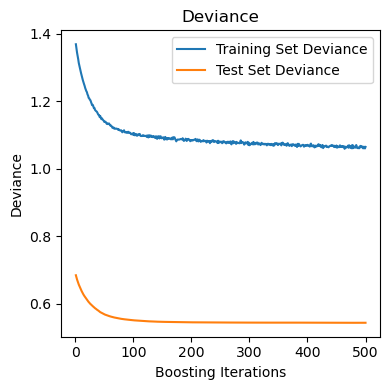

In [15]:
# X, y (Block B)
X = blocks["B_ratings"]["X"].copy()
y = blocks["B_ratings"]["y"].copy()

if X.shape[1] == 0:
    raise ValueError("Block B has no review_scores_* columns. Check cols_B creation.")

X = X.apply(pd.to_numeric, errors="coerce")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)
X.shape, y.mean()

imputer = gb_model.named_steps["imputer"]
gb_clf  = gb_model.named_steps["clf"]

# Transform X (pipeline preprocessing)
Xtr = imputer.transform(X_train)
Xte = imputer.transform(X_test)

# Compute deviance (log loss) per stage
n_est = gb_clf.n_estimators

test_score = np.zeros(n_est, dtype=np.float64)

# staged_predict_proba yields proba for each stage
for i, proba in enumerate(gb_clf.staged_predict_proba(Xte)):
    test_score[i] = log_loss(y_test, proba, labels=gb_clf.classes_)

# Plot
plt.figure(figsize=(4, 4))
plt.title("Deviance")
plt.plot(np.arange(n_est) + 1, gb_clf.train_score_, label="Training Set Deviance")
plt.plot(np.arange(n_est) + 1, test_score, label="Test Set Deviance")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

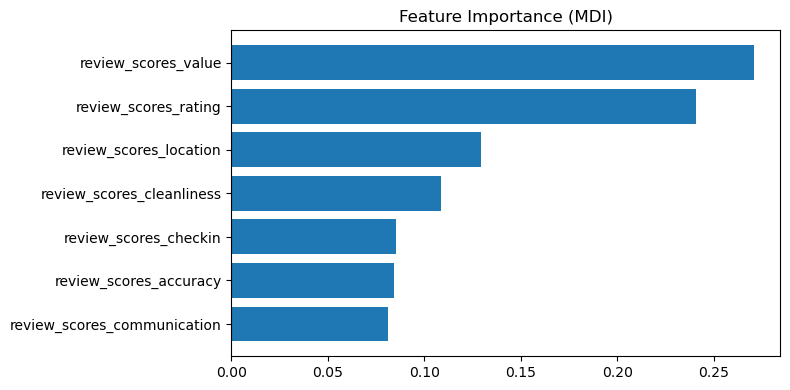

In [16]:
# X, y (Block B)
X = blocks["B_ratings"]["X"].copy()
y = blocks["B_ratings"]["y"].copy()

if X.shape[1] == 0:
    raise ValueError("Block B has no review_scores_* columns. Check cols_B creation.")

X = X.apply(pd.to_numeric, errors="coerce")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)
X.shape, y.mean()

gb_est = gb_model.named_steps["clf"]

feature_importance = gb_est.feature_importances_
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + 0.5

plt.figure(figsize=(8, 4))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, X.columns.to_numpy()[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.tight_layout()
plt.show()

### Block B Decision tree

In [48]:
# X, y (Block B)
X = blocks["B_ratings"]["X"].copy().apply(pd.to_numeric, errors="coerce")
y = blocks["B_ratings"]["y"].copy().astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=15, stratify=y
)

dtc = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", DecisionTreeClassifier(
        max_depth=4,
        min_samples_leaf=200,
        class_weight="balanced",
        random_state=42
    ))
])

dtc.fit(X_train, y_train)

pred = dtc.predict(X_test)
prob = dtc.predict_proba(X_test)[:, 1]

print("Confusion matrix:\n", confusion_matrix(y_test, pred))
print("\nClassification report:\n", classification_report(y_test, pred, digits=4))

print("\nAUC   :", roc_auc_score(y_test, prob))
print("PR-AUC:", average_precision_score(y_test, prob))
print("Acc  :", accuracy_score(y_test, pred))
print("F1   :", f1_score(y_test, pred))

Confusion matrix:
 [[4762 2408]
 [1671 4957]]

Classification report:
               precision    recall  f1-score   support

           0     0.7402    0.6642    0.7001      7170
           1     0.6730    0.7479    0.7085      6628

    accuracy                         0.7044     13798
   macro avg     0.7066    0.7060    0.7043     13798
weighted avg     0.7080    0.7044    0.7042     13798


AUC   : 0.755328846641062
PR-AUC: 0.6960973991251731
Acc  : 0.7043774460066676
F1   : 0.708497105695705


In [49]:
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)

prob = dtc.predict_proba(X_test)[:, 1]   
pred = (prob >= 0.5).astype(int)

print_evaluate(y_test, prob, pred, name="DecisionTree (test)")

DecisionTree (test)
AUC      : 0.6334
PR-AUC   : 0.6086
Accuracy : 0.6636
F1       : 0.6323

Confusion matrix:
 [[5166 2004]
 [2637 3991]]

Classification report:
               precision    recall  f1-score   support

           0     0.6621    0.7205    0.6900      7170
           1     0.6657    0.6021    0.6323      6628

    accuracy                         0.6636     13798
   macro avg     0.6639    0.6613    0.6612     13798
weighted avg     0.6638    0.6636    0.6623     13798



In [50]:
importance = pd.Series(dtc.feature_importances_, index=X.columns).sort_values(ascending=False)
importance

review_scores_rating           0.262067
review_scores_location         0.184216
review_scores_value            0.148001
review_scores_cleanliness      0.110984
review_scores_accuracy         0.101214
review_scores_checkin          0.099477
review_scores_communication    0.094041
dtype: float64

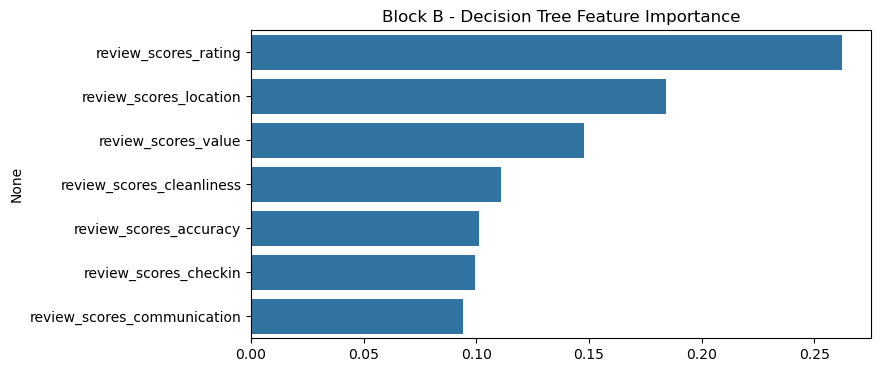

In [51]:
plt.figure(figsize=(8,4))
sns.barplot(x=importance.values, y=importance.index)
plt.title("Block B - Decision Tree Feature Importance")
plt.show()

[Text(0.3745866662141508, 0.9875, 'x[0] <= 4.695\ngini = 0.499\nsamples = 32193\nvalue = [16730, 15463]'),
 Text(0.06774405053074614, 0.9625, 'x[0] <= 4.525\ngini = 0.295\nsamples = 8005\nvalue = [6567, 1438]'),
 Text(0.2211653583724485, 0.9750000000000001, 'True  '),
 Text(0.028615738538859268, 0.9375, 'x[2] <= 4.655\ngini = 0.253\nsamples = 5822\nvalue = [4958, 864]'),
 Text(0.012762626515473895, 0.9125, 'x[3] <= 4.775\ngini = 0.175\nsamples = 1637\nvalue = [1478, 159]'),
 Text(0.005938126667056052, 0.8875, 'x[6] <= 3.29\ngini = 0.127\nsamples = 999\nvalue = [931, 68]'),
 Text(0.0037325367621495182, 0.8625, 'x[1] <= 3.94\ngini = 0.015\nsamples = 136\nvalue = [135, 1]'),
 Text(0.0035545320283361286, 0.8375, 'gini = 0.0\nsamples = 103\nvalue = [103, 0]'),
 Text(0.003910541495962908, 0.8375, 'x[6] <= 2.835\ngini = 0.059\nsamples = 33\nvalue = [32, 1]'),
 Text(0.0037325367621495182, 0.8125, 'x[6] <= 2.585\ngini = 0.198\nsamples = 9\nvalue = [8, 1]'),
 Text(0.0035545320283361286, 0.7875, 

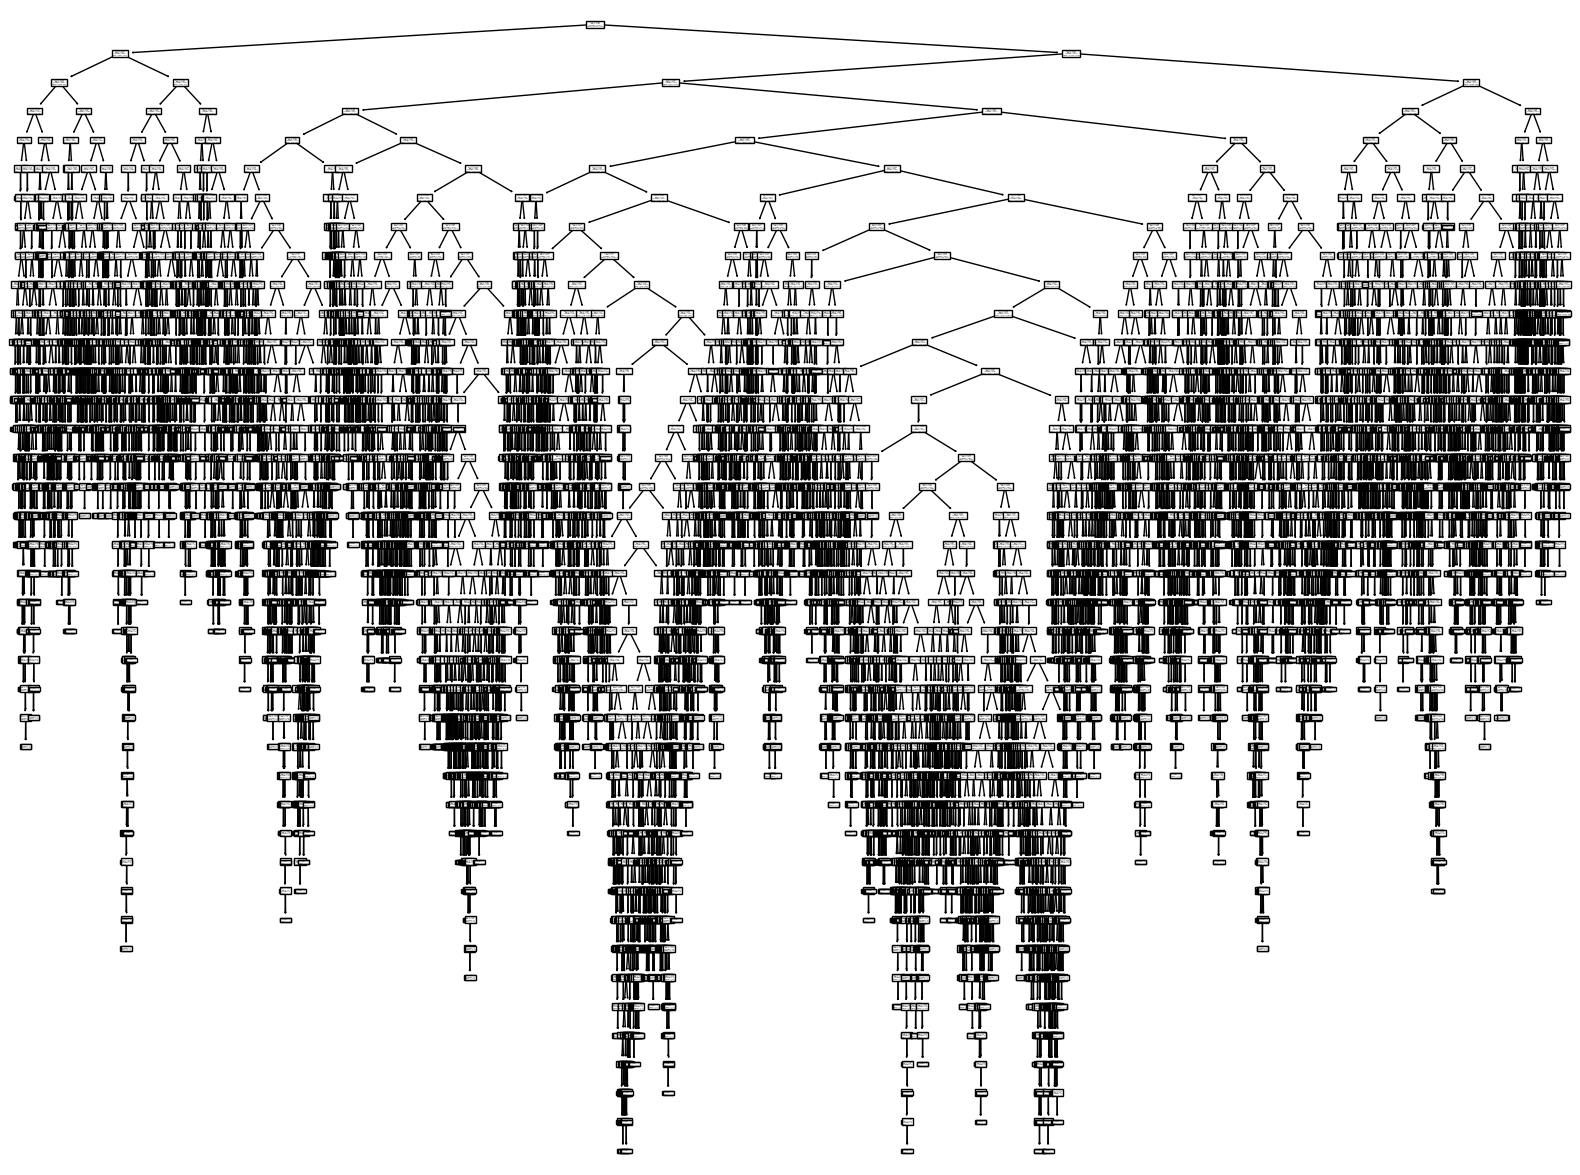

In [52]:
plt.rcParams['figure.figsize'] = [20, 15]
tree.plot_tree(dtc) 

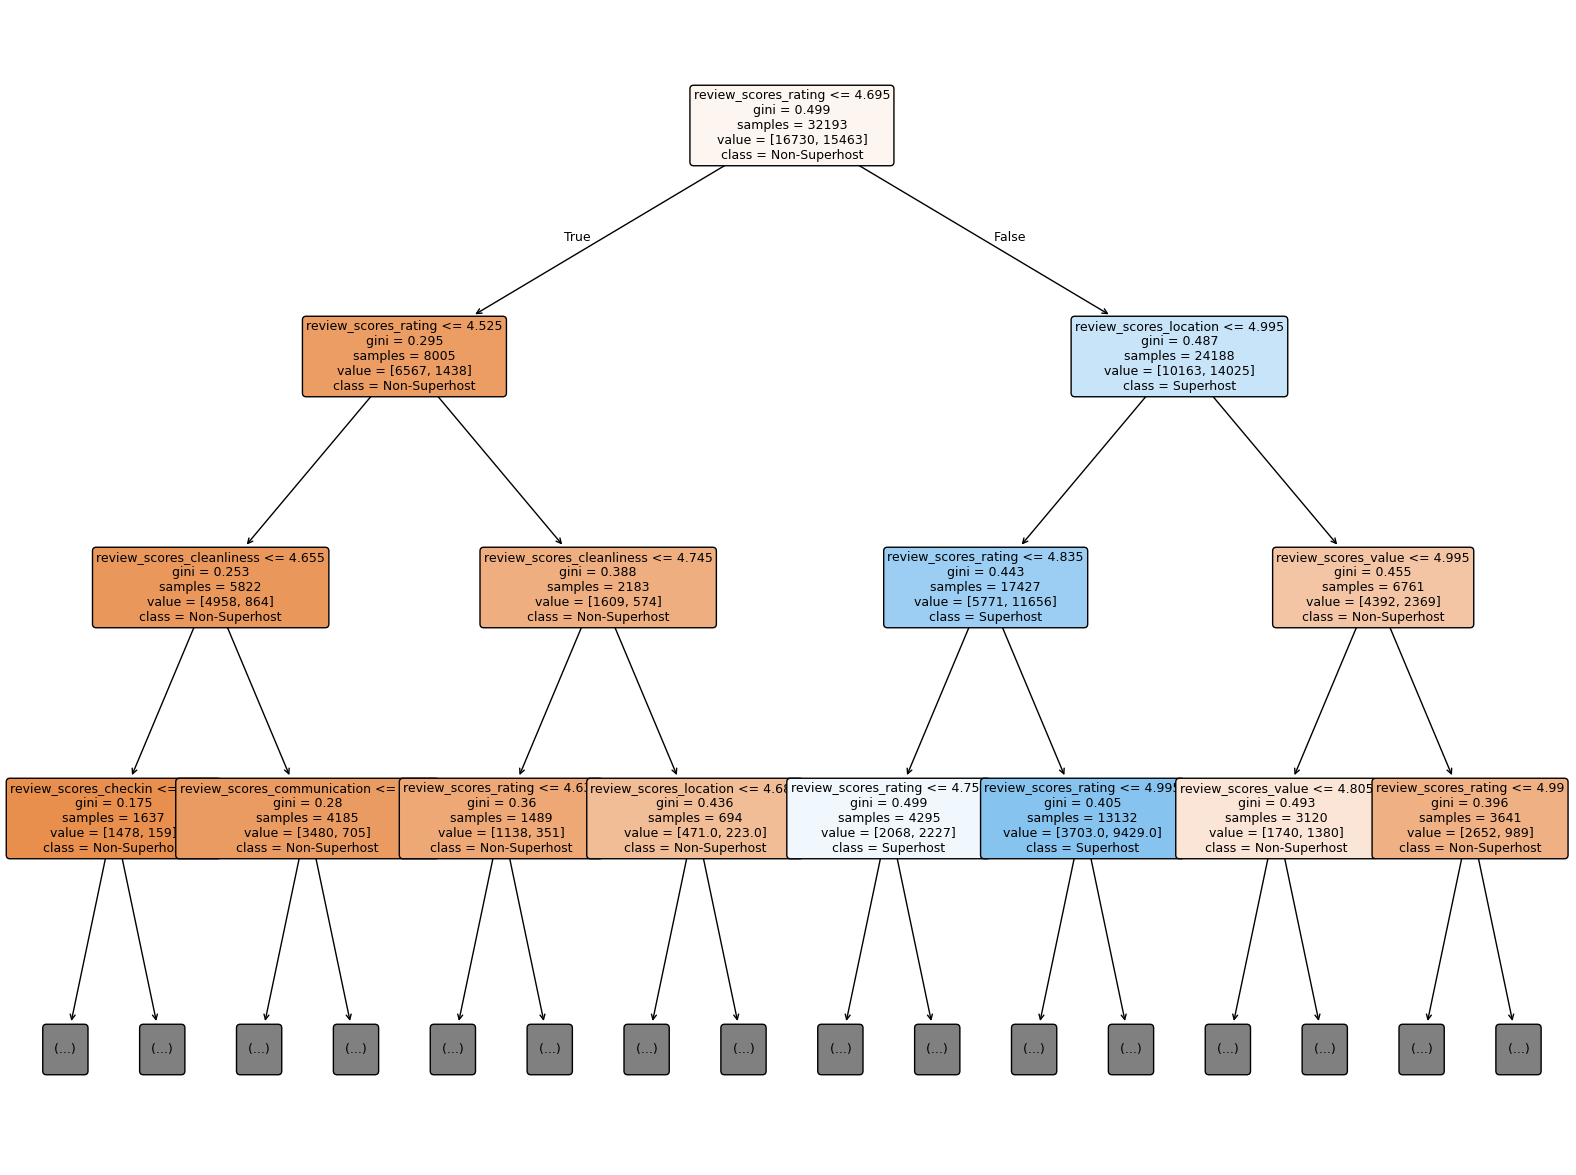

In [53]:
plt.figure(figsize=(20, 15))
tree.plot_tree(
    dtc,feature_names=X.columns,class_names=["Non-Superhost","Superhost"],filled=True,rounded=True,max_depth=3,fontsize=9)
plt.show()

### Block B K-means

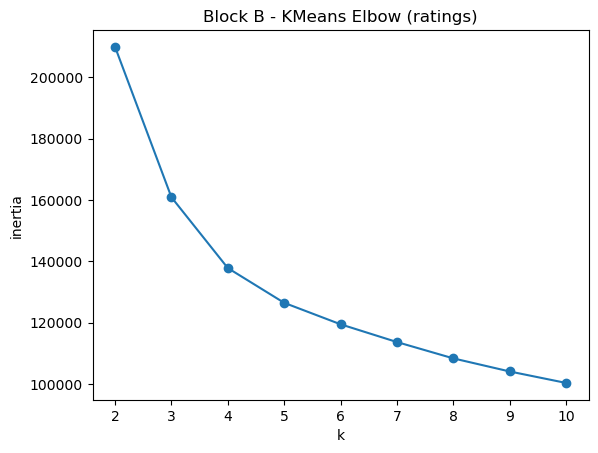

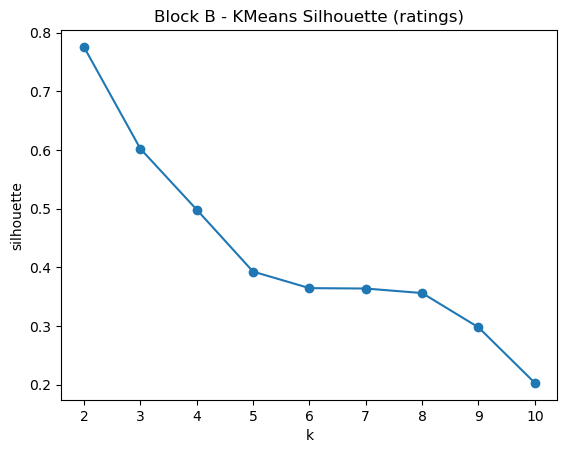

In [24]:
# X, y (Block B)
X = blocks["B_ratings"]["X"].copy()
y = blocks["B_ratings"]["y"].copy()

XB = X.apply(pd.to_numeric, errors="coerce")
XB = XB.fillna(XB.median(numeric_only=True))

XBs = StandardScaler().fit_transform(XB)

#Elbow + Silhouette
Ks = range(2, 11)
inertias, sils = [], []

for k in Ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(XBs)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(XBs, labels, sample_size=5000, random_state=42, n_jobs=1))

plt.figure()
plt.plot(list(Ks), inertias, marker="o")
plt.xlabel("k"); plt.ylabel("inertia")
plt.title("Block B - KMeans Elbow (ratings)")
plt.show()

plt.figure()
plt.plot(list(Ks), sils, marker="o")
plt.xlabel("k"); plt.ylabel("silhouette")
plt.title("Block B - KMeans Silhouette (ratings)")
plt.show()

count  superhost_rate
cluster_id                       
0           35397        0.539424
1            1322        0.104387
2             143        0.055944
3            9129        0.312301

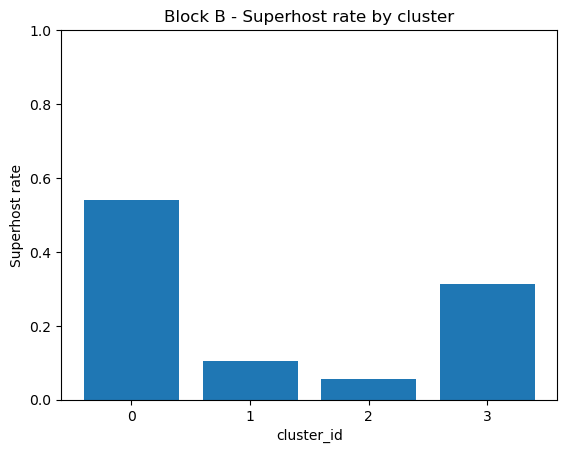

In [27]:
k_final = 4
kmeans = KMeans(n_clusters=k_final, n_init=20, random_state=42)

cluster_id = kmeans.fit_predict(XBs)   

tmp = XB.copy()                        
tmp["cluster_id"] = cluster_id
tmp["is_superhost"] = y.loc[tmp.index].astype(int).values

rate = (tmp.groupby("cluster_id")["is_superhost"]
          .agg(count="size", superhost_rate="mean")
          .sort_index())

display(rate)

plt.figure()
plt.bar(rate.index.astype(str), rate["superhost_rate"].values)
plt.xlabel("cluster_id")
plt.ylabel("Superhost rate")
plt.title("Block B - Superhost rate by cluster")
plt.ylim(0, 1)
plt.show()

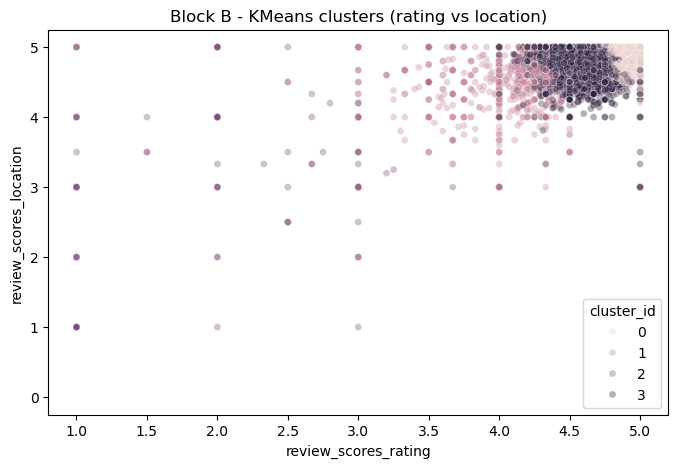

In [28]:
tmp = XB.copy()
tmp["cluster_id"] = cluster_id

plt.figure(figsize=(8,5))
sns.scatterplot(
    data=tmp,
    x="review_scores_rating",
    y="review_scores_location",
    hue="cluster_id",
    alpha=0.35,
    s=25
)
plt.title("Block B - KMeans clusters (rating vs location)")
plt.show()

### Block C Review Activity-Logistic regression

In [30]:
# X, y (Block C)
X = blocks["C_activity"]["X"].copy()
y = blocks["C_activity"]["y"].copy().astype(int)

if X.shape[1] == 0:
    raise ValueError("Block C has no activity columns. Check cols_C creation.")

# numeric
X = X.apply(pd.to_numeric, errors="coerce")

#log1p for non-negative count/day features
X_log = X.copy()
for c in X_log.columns:
    col = X_log[c]
    if (col.dropna() >= 0).all():
        X_log[c] = np.log1p(col)

# split
X_train, X_test, y_train, y_test = train_test_split(
    X_log, y, test_size=0.30, random_state=0, stratify=y
)

# pipeline
clf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=3000, class_weight="balanced"))
])

clf.fit(X_train, y_train)

test_prob = clf.predict_proba(X_test)[:, 1]
test_pred = (test_prob >= 0.5).astype(int)

train_prob = clf.predict_proba(X_train)[:, 1]
train_pred = (train_prob >= 0.5).astype(int)

def print_evaluate(y_true, y_prob, y_pred, name=""):
    auc = metrics.roc_auc_score(y_true, y_prob)
    ap  = metrics.average_precision_score(y_true, y_prob)  # PR-AUC
    acc = metrics.accuracy_score(y_true, y_pred)
    f1  = metrics.f1_score(y_true, y_pred)

    if name:
        print(name)

    print(f"AUC      : {auc:.4f}")
    print(f"PR-AUC   : {ap:.4f}")
    print(f"Accuracy : {acc:.4f}")
    print(f"F1       : {f1:.4f}")

    print("\nConfusion matrix:\n", metrics.confusion_matrix(y_true, y_pred))
    print("\nClassification report:\n", metrics.classification_report(y_true, y_pred, digits=4))

print_evaluate(y_test,  test_prob,  test_pred,  "Test set evaluation (Block C)")
print("\n" + "-"*40 + "\n")
print_evaluate(y_train, train_prob, train_pred, "Train set evaluation (Block C)")

Test set evaluation (Block C)
AUC      : 0.8124
PR-AUC   : 0.7821
Accuracy : 0.7599
F1       : 0.7557

Confusion matrix:
 [[5360 1810]
 [1503 5125]]

Classification report:
               precision    recall  f1-score   support

           0     0.7810    0.7476    0.7639      7170
           1     0.7390    0.7732    0.7557      6628

    accuracy                         0.7599     13798
   macro avg     0.7600    0.7604    0.7598     13798
weighted avg     0.7608    0.7599    0.7600     13798


----------------------------------------

Train set evaluation (Block C)
AUC      : 0.8140
PR-AUC   : 0.7856
Accuracy : 0.7604
F1       : 0.7574

Confusion matrix:
 [[12443  4287]
 [ 3425 12038]]

Classification report:
               precision    recall  f1-score   support

           0     0.7842    0.7438    0.7634     16730
           1     0.7374    0.7785    0.7574     15463

    accuracy                         0.7604     32193
   macro avg     0.7608    0.7611    0.7604     32193
weigh

In [31]:
#Cross validation (AUC)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_auc = cross_val_score(clf, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_acc = cross_val_score(clf, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
cv_f1  = cross_val_score(clf, X, y, cv=cv, scoring="f1", n_jobs=-1)

print("CV AUC (5-fold):", cv_auc.mean(), "±", cv_auc.std())
print("CV ACC (5-fold):", cv_acc.mean(), "±", cv_acc.std())
print("CV F1  (5-fold):", cv_f1.mean(),  "±", cv_f1.std())
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc = cross_val_score(clf, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)

print("CV AUC (5-fold):", cv_auc)
print("Mean CV AUC    :", cv_auc.mean())

# Coefficients table
coef = clf.named_steps["clf"].coef_.ravel()
coef_df = pd.DataFrame({"Feature": X.columns, "Coefficient": coef}).sort_values(
    "Coefficient", ascending=False
)
coef_df

CV AUC (5-fold): 0.8121754214320214 ± 0.005211057982652756
CV ACC (5-fold): 0.7486245290613545 ± 0.0064216387036480135
CV F1  (5-fold): 0.7111522075162237 ± 0.008808551809805493
CV AUC (5-fold): [0.80843429 0.81814832 0.81034594 0.80554481 0.81840374]
Mean CV AUC    : 0.8121754214320214


Feature  Coefficient
2   number_of_reviews_ltm     1.133495
0       number_of_reviews     0.189765
1       reviews_per_month     0.066563
3  number_of_reviews_l30d    -0.176949
4  days_since_last_review    -0.193153

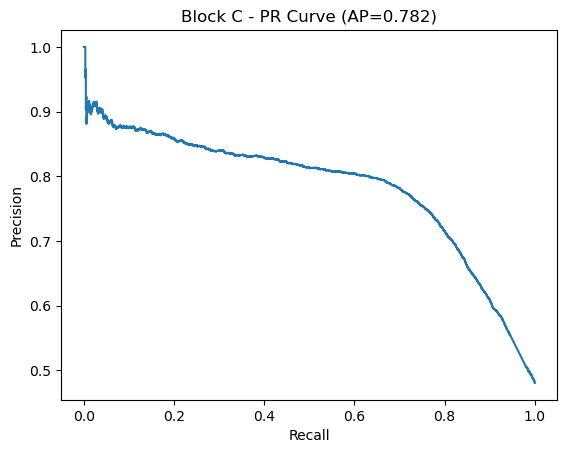

In [32]:
p, r, _ = precision_recall_curve(y_test, test_prob)
ap = average_precision_score(y_test, test_prob)

plt.figure()
plt.plot(r, p)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Block C - PR Curve (AP={ap:.3f})")
plt.show()

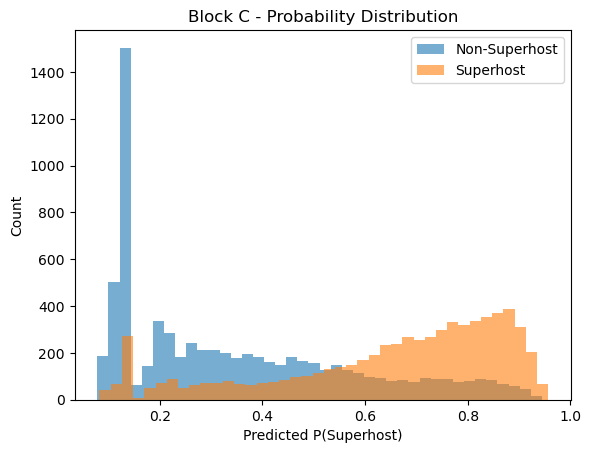

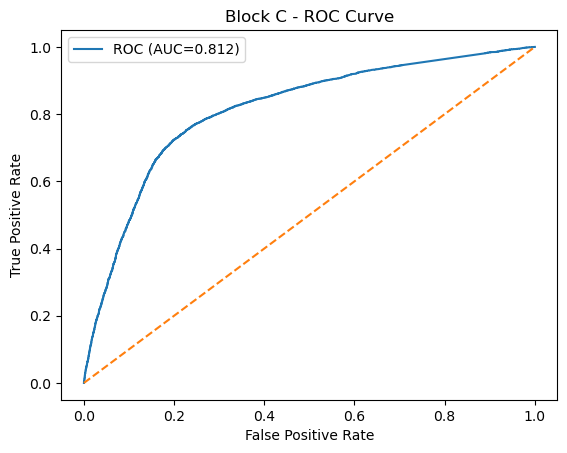

In [33]:
#Plots Probability distribution
plt.figure()
plt.hist(test_prob[y_test == 0], bins=40, alpha=0.6, label="Non-Superhost")
plt.hist(test_prob[y_test == 1], bins=40, alpha=0.6, label="Superhost")
plt.xlabel("Predicted P(Superhost)")
plt.ylabel("Count")
plt.legend()
plt.title("Block C - Probability Distribution")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, test_prob)
auc = roc_auc_score(y_test, test_prob)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Block C - ROC Curve")
plt.legend()
plt.show()

### Block C polynomial features with Logistic

In [34]:
X = blocks["C_activity"]["X"].copy()
y = blocks["C_activity"]["y"].copy().astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)

clf_poly = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),  
    ("scaler", StandardScaler(with_mean=False)),  # poly feature 
    ("clf", LogisticRegression(max_iter=5000, class_weight="balanced"))
])

clf_poly.fit(X_train, y_train)
prob = clf_poly.predict_proba(X_test)[:, 1]
pred = (prob >= 0.5).astype(int)

#metrics
auc = metrics.roc_auc_score(y_test, prob)
ap  = metrics.average_precision_score(y_test, prob)   # PR-AUC
acc = metrics.accuracy_score(y_test, pred)
f1  = metrics.f1_score(y_test, pred)

print(f"AUC      : {auc:.4f}")
print(f"PR-AUC   : {ap:.4f}")
print(f"Accuracy : {acc:.4f}")
print(f"F1       : {f1:.4f}")
print("\nConfusion matrix:\n", metrics.confusion_matrix(y_test, pred))
print("\nClassification report:\n", metrics.classification_report(y_test, pred, digits=4))

AUC      : 0.8109
PR-AUC   : 0.7817
Accuracy : 0.7608
F1       : 0.7353

Confusion matrix:
 [[5915 1255]
 [2045 4583]]

Classification report:
               precision    recall  f1-score   support

           0     0.7431    0.8250    0.7819      7170
           1     0.7850    0.6915    0.7353      6628

    accuracy                         0.7608     13798
   macro avg     0.7641    0.7582    0.7586     13798
weighted avg     0.7632    0.7608    0.7595     13798



### Block C RandomForestClassifier

In [35]:
X = blocks["C_activity"]["X"].copy()
y = blocks["C_activity"]["y"].copy().astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)

rf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(
        n_estimators=500, random_state=42,
        class_weight="balanced_subsample",
        n_jobs=-1
    ))
])

rf.fit(X_train, y_train)

imp = (pd.Series(rf.named_steps["clf"].feature_importances_, index=X.columns)
         .sort_values(ascending=False))

imp

reviews_per_month         0.278130
number_of_reviews_ltm     0.253490
days_since_last_review    0.249211
number_of_reviews         0.194990
number_of_reviews_l30d    0.024180
dtype: float64

In [36]:
X = blocks["C_activity"]["X"].copy()
y = blocks["C_activity"]["y"].copy().astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)

r = permutation_importance(
    clf_poly, X_test, y_test,
    n_repeats=10, random_state=42, scoring="roc_auc"
)

imp = pd.Series(r.importances_mean, index=X.columns).sort_values(ascending=False)
imp

number_of_reviews_ltm     0.326173
days_since_last_review    0.045845
number_of_reviews_l30d    0.025337
number_of_reviews         0.018682
reviews_per_month         0.013338
dtype: float64

### Block C Gradient boost

In [37]:
X = blocks["C_activity"]["X"].copy()
y = blocks["C_activity"]["y"].copy().astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)
X.shape, y.mean()

def run_gb_block_exact(X_train, y_train, X_test, y_test, X_full, y_full,
                       model_name="GradientBoostingClassifier",
                       params=None, cv=5, threshold=0.5):
    if params is None:
        params = {
            "n_estimators": 500,
            "max_depth": 3,
            "learning_rate": 0.05,
            "subsample": 0.8,
            "random_state": 42
        }

    gb_clf = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", GradientBoostingClassifier(**params))
    ])

    # fit
    gb_clf.fit(X_train, y_train)

    # predict (test/train)
    test_prob  = gb_clf.predict_proba(X_test)[:, 1]
    test_pred  = (test_prob >= threshold).astype(int)

    train_prob = gb_clf.predict_proba(X_train)[:, 1]
    train_pred = (train_prob >= threshold).astype(int)

    # ----- block 1: confusion + report (test) -----
    print("Confusion matrix:")
    print(metrics.confusion_matrix(y_test, test_pred))

    print("\nClassification report:")
    print(metrics.classification_report(y_test, test_pred, digits=4))

    # metric helper
    def scores(y_true, prob, pred):
        auc = metrics.roc_auc_score(y_true, prob)
        ap  = metrics.average_precision_score(y_true, prob)
        acc = metrics.accuracy_score(y_true, pred)
        f1  = metrics.f1_score(y_true, pred)
        return auc, ap, acc, f1

    # ----- block 2: test evaluation -----
    auc_t, ap_t, acc_t, f1_t = scores(y_test, test_prob, test_pred)
    print("\nTest set evaluation:")
    print(f"AUC      : {auc_t}")
    print(f"PR-AUC   : {ap_t}")
    print(f"Accuracy : {acc_t}")
    print(f"F1       : {f1_t}")

    # ----- block 3: train evaluation -----
    auc_tr, ap_tr, acc_tr, f1_tr = scores(y_train, train_prob, train_pred)
    print("\nTrain set evaluation:")
    print(f"AUC      : {auc_tr}")
    print(f"PR-AUC   : {ap_tr}")
    print(f"Accuracy : {acc_tr}")
    print(f"F1       : {f1_tr}")

    # ----- block 4: CV + evaluate_df -----
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    cv_list = cross_val_score(gb_clf, X_full, y_full, cv=skf, scoring="roc_auc", n_jobs=-1)

    evaluate_df = pd.DataFrame(
        data=[[
            model_name,
            auc_t, ap_t, acc_t, f1_t,
            cv_list
        ]],
        columns=["Model", "AUC", "PR-AUC", "Accuracy", "F1", "Cross Validation (AUC)"]
    )

    return gb_clf, evaluate_df

gb_model, evaluate_df_gb = run_gb_block_exact(
    X_train, y_train, X_test, y_test,
    X, y,
    model_name="GradientBoostingClassifier",
    cv=5,
    threshold=0.5
)

evaluate_df_gb

Confusion matrix:
[[5704 1466]
 [1777 4851]]

Classification report:
              precision    recall  f1-score   support

           0     0.7625    0.7955    0.7786      7170
           1     0.7679    0.7319    0.7495      6628

    accuracy                         0.7650     13798
   macro avg     0.7652    0.7637    0.7641     13798
weighted avg     0.7651    0.7650    0.7646     13798


Test set evaluation:
AUC      : 0.8150464219670743
PR-AUC   : 0.7900434819462601
Accuracy : 0.7649659370923322
F1       : 0.7494785631517961

Train set evaluation:
AUC      : 0.8338576334329728
PR-AUC   : 0.8209506872211981
Accuracy : 0.7718448109837542
F1       : 0.7579821410919635


Model       AUC    PR-AUC  Accuracy        F1  \
0  GradientBoostingClassifier  0.815046  0.790043  0.764966  0.749479   

                              Cross Validation (AUC)  
0  [0.8131210226664811, 0.8219504745705568, 0.815...

In [38]:
imp = pd.Series(
    gb_model.named_steps["clf"].feature_importances_,
    index=X.columns
).sort_values(ascending=False)

imp

number_of_reviews_ltm     0.878378
days_since_last_review    0.041406
number_of_reviews         0.040258
reviews_per_month         0.034535
number_of_reviews_l30d    0.005423
dtype: float64

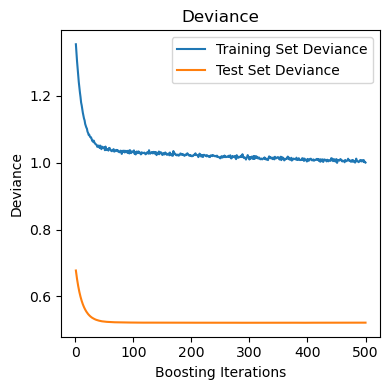

In [39]:
X = blocks["C_activity"]["X"].copy()
y = blocks["C_activity"]["y"].copy().astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)
X.shape, y.mean()

imputer = gb_model.named_steps["imputer"]
gb_clf  = gb_model.named_steps["clf"]

# Transform X (pipeline preprocessing)
Xtr = imputer.transform(X_train)
Xte = imputer.transform(X_test)

# Compute deviance (log loss) per stage
n_est = gb_clf.n_estimators

test_score = np.zeros(n_est, dtype=np.float64)


for i, proba in enumerate(gb_clf.staged_predict_proba(Xte)):
    test_score[i] = log_loss(y_test, proba, labels=gb_clf.classes_)

# Plot
plt.figure(figsize=(4, 4))
plt.title("Deviance")
plt.plot(np.arange(n_est) + 1, gb_clf.train_score_, label="Training Set Deviance")
plt.plot(np.arange(n_est) + 1, test_score, label="Test Set Deviance")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

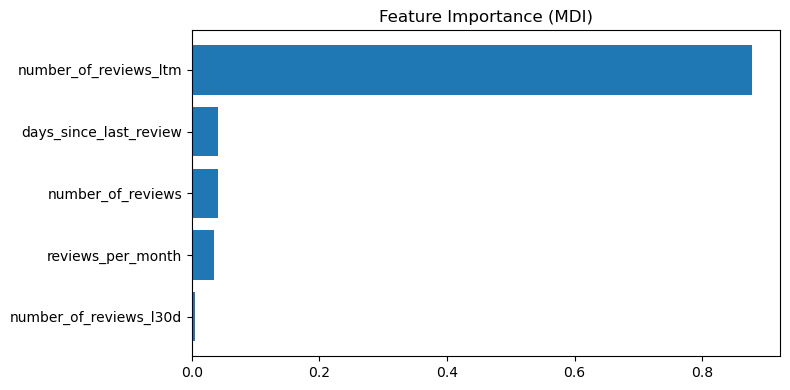

In [40]:
X = blocks["C_activity"]["X"].copy()
y = blocks["C_activity"]["y"].copy().astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)
X.shape, y.mean()

gb_est = gb_model.named_steps["clf"]

feature_importance = gb_est.feature_importances_
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + 0.5

plt.figure(figsize=(8, 4))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, X.columns.to_numpy()[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.tight_layout()
plt.show()

### Block C Decision tree

In [41]:
# X, y (Block C)
X = blocks["C_activity"]["X"].copy().apply(pd.to_numeric, errors="coerce")
y = blocks["C_activity"]["y"].copy().astype(int)

if X.shape[1] == 0:
    raise ValueError("Block C has no activity columns. Check cols_C creation.")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=15, stratify=y
)

dtc = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", DecisionTreeClassifier(
        max_depth=4,
        min_samples_leaf=200,
        class_weight="balanced",
        random_state=42
    ))
])

dtc.fit(X_train, y_train)

pred = dtc.predict(X_test)
prob = dtc.predict_proba(X_test)[:, 1]

print("Confusion matrix:\n", confusion_matrix(y_test, pred))
print("\nClassification report:\n", classification_report(y_test, pred, digits=4))

print("\nAUC    :", roc_auc_score(y_test, prob))
print("PR-AUC :", average_precision_score(y_test, prob))
print("Acc    :", accuracy_score(y_test, pred))
print("F1     :", f1_score(y_test, pred))

Confusion matrix:
 [[5683 1487]
 [1778 4850]]

Classification report:
               precision    recall  f1-score   support

           0     0.7617    0.7926    0.7768      7170
           1     0.7653    0.7317    0.7482      6628

    accuracy                         0.7634     13798
   macro avg     0.7635    0.7622    0.7625     13798
weighted avg     0.7634    0.7634    0.7631     13798


AUC    : 0.8124959177455181
PR-AUC : 0.767866008387858
Acc    : 0.7633715031163937
F1     : 0.7481681450057848


In [42]:
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)

prob = dtc.predict_proba(X_test)[:, 1]   
pred = (prob >= 0.5).astype(int)

print_evaluate(y_test, prob, pred, name="DecisionTree (test)")

DecisionTree (test)
AUC      : 0.6493
PR-AUC   : 0.6087
Accuracy : 0.6738
F1       : 0.6502

Confusion matrix:
 [[5114 2056]
 [2445 4183]]

Classification report:
               precision    recall  f1-score   support

           0     0.6765    0.7132    0.6944      7170
           1     0.6705    0.6311    0.6502      6628

    accuracy                         0.6738     13798
   macro avg     0.6735    0.6722    0.6723     13798
weighted avg     0.6736    0.6738    0.6732     13798



In [43]:
importance = pd.Series(dtc.feature_importances_, index=X.columns).sort_values(ascending=False)
importance

number_of_reviews_ltm     0.387194
days_since_last_review    0.228698
reviews_per_month         0.217292
number_of_reviews         0.146009
number_of_reviews_l30d    0.020806
dtype: float64

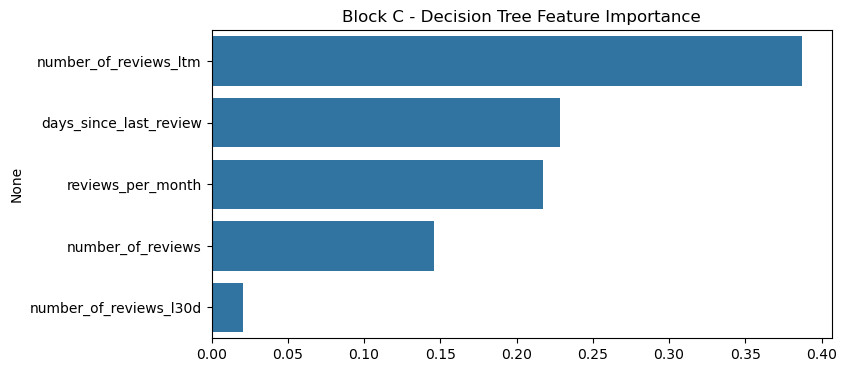

In [44]:
plt.figure(figsize=(8,4))
sns.barplot(x=importance.values, y=importance.index)
plt.title("Block C - Decision Tree Feature Importance")
plt.show()

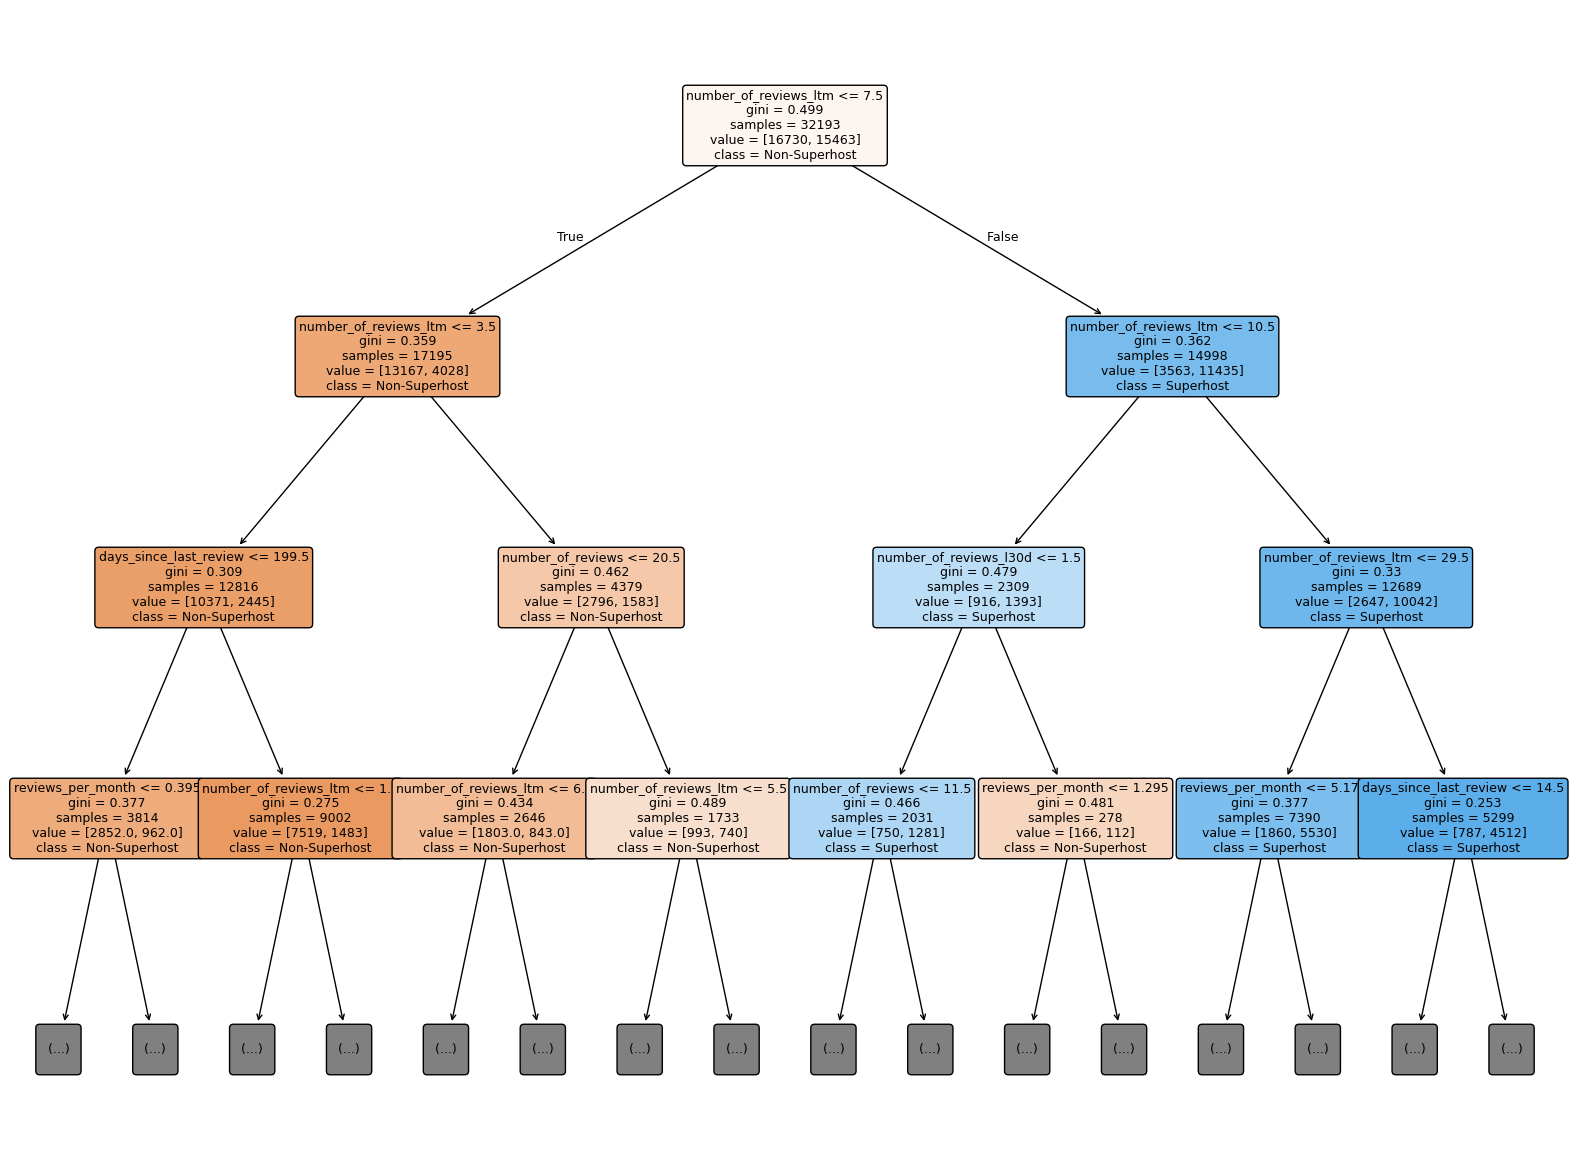

In [45]:
plt.figure(figsize=(20, 15))
tree.plot_tree(
    dtc,feature_names=X.columns,class_names=["Non-Superhost","Superhost"],filled=True,rounded=True,max_depth=3,fontsize=9)
plt.show()

[Text(0.5220343165095046, 0.9901960784313726, 'x[2] <= 7.5\ngini = 0.499\nsamples = 32193\nvalue = [16730, 15463]'),
 Text(0.3165652621240163, 0.9705882352941176, 'x[2] <= 3.5\ngini = 0.359\nsamples = 17195\nvalue = [13167, 4028]'),
 Text(0.4192997893167605, 0.9803921568627452, 'True  '),
 Text(0.17794424610795484, 0.9509803921568627, 'x[4] <= 199.5\ngini = 0.309\nsamples = 12816\nvalue = [10371, 2445]'),
 Text(0.06291236487284875, 0.9313725490196079, 'x[1] <= 0.395\ngini = 0.377\nsamples = 3814\nvalue = [2852.0, 962.0]'),
 Text(0.015626103633670427, 0.9117647058823529, 'x[4] <= 12.5\ngini = 0.352\nsamples = 1871\nvalue = [1445, 426]'),
 Text(0.0006848862760739417, 0.8921568627450981, 'x[4] <= 0.5\ngini = 0.134\nsamples = 69\nvalue = [64, 5]'),
 Text(0.0005136647070554562, 0.8725490196078431, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.0008561078450924271, 0.8725490196078431, 'x[4] <= 4.5\ngini = 0.111\nsamples = 68\nvalue = [64, 4]'),
 Text(0.0005136647070554562, 0.85294117647

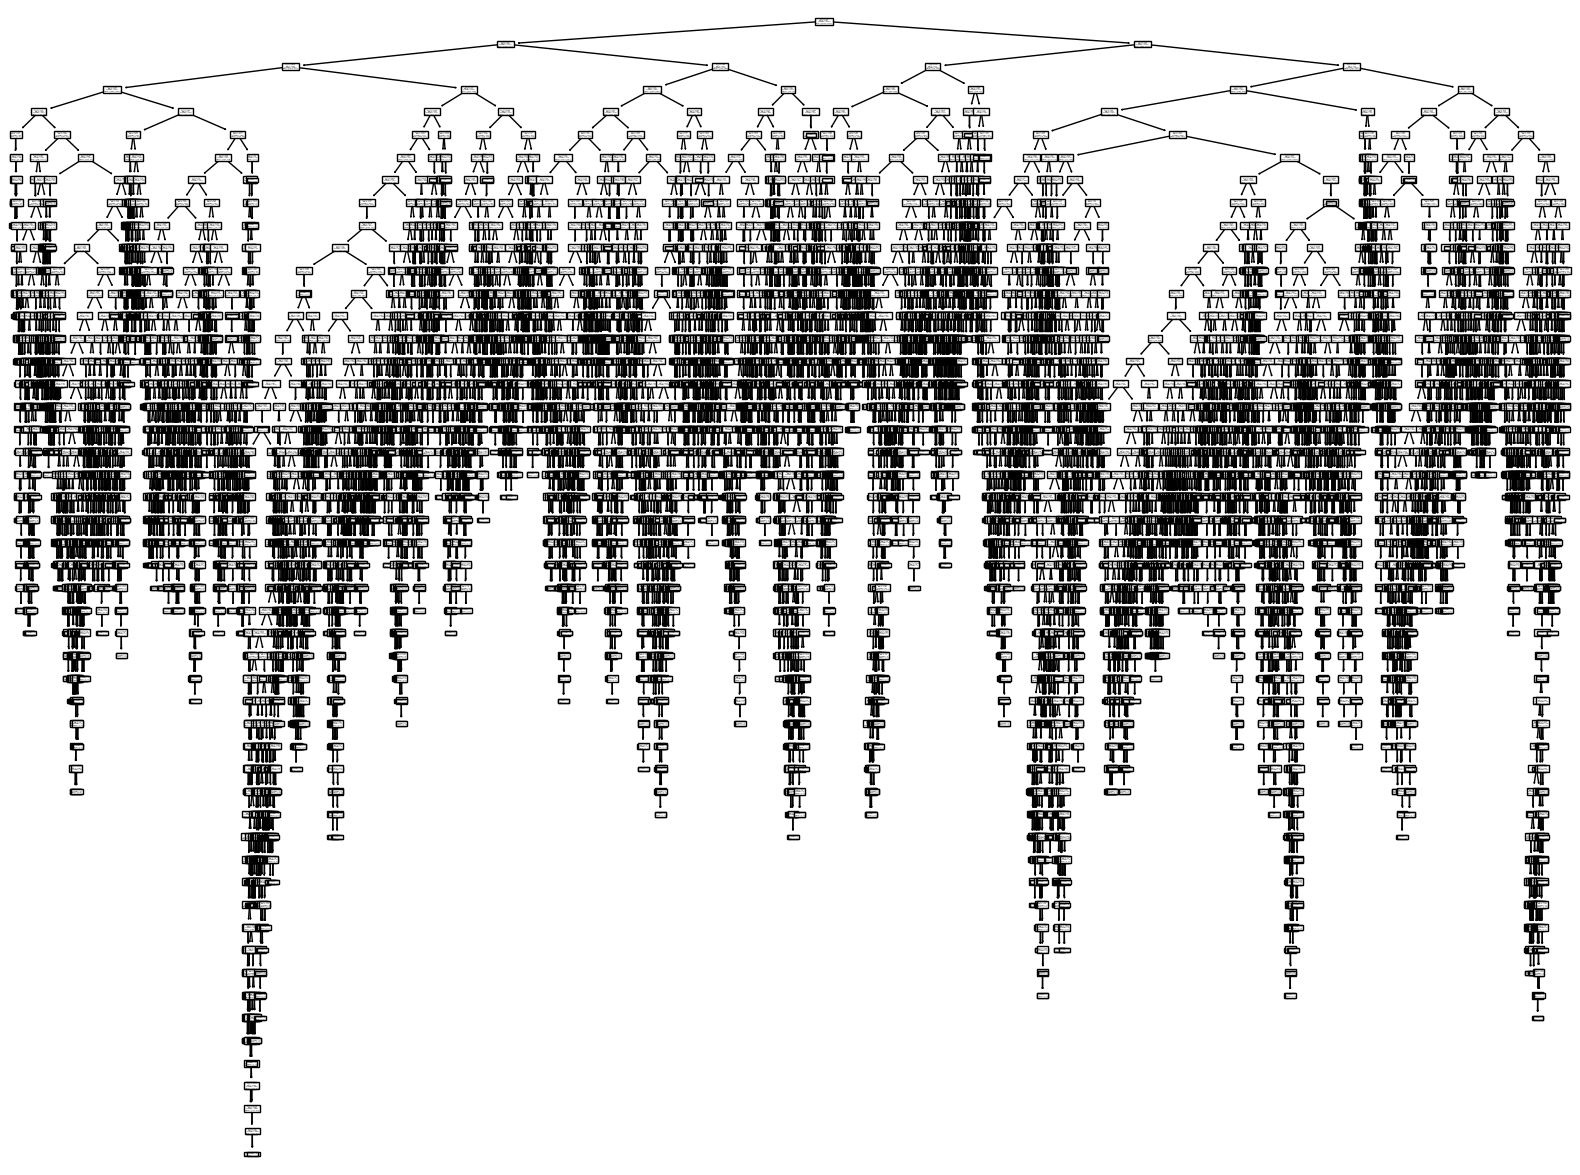

In [47]:
plt.rcParams['figure.figsize'] = [20, 15]
tree.plot_tree(dtc) 

### Block C K-means

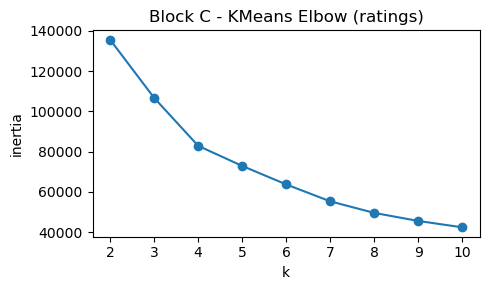

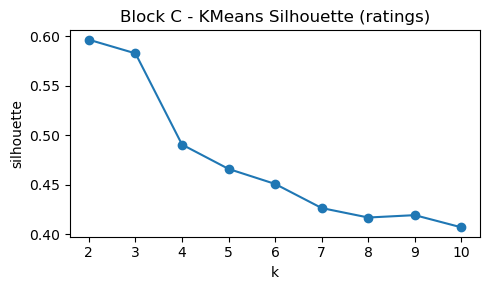

In [71]:
# X, y (Block C)
X = blocks["C_activity"]["X"].copy()
y = blocks["C_activity"]["y"].copy()

XC = X.apply(pd.to_numeric, errors="coerce")
XC = XC.fillna(XC.median(numeric_only=True))

XCs = StandardScaler().fit_transform(XC)

Ks = range(2, 11)
inertias, sils = [], []

for k in Ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(XCs)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(XCs, labels, sample_size=5000, random_state=42, n_jobs=1))

plt.figure(figsize=(5,3))
plt.plot(list(Ks), inertias, marker="o")
plt.xlabel("k"); plt.ylabel("inertia")
plt.title("Block C - KMeans Elbow (ratings)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(list(Ks), sils, marker="o")
plt.xlabel("k"); plt.ylabel("silhouette")
plt.title("Block C - KMeans Silhouette (ratings)")
plt.tight_layout()
plt.show()

count  superhost_rate
cluster_id                       
0           10288        0.776147
1           31636        0.370116
2            2523        0.874752
3            1544        0.123057

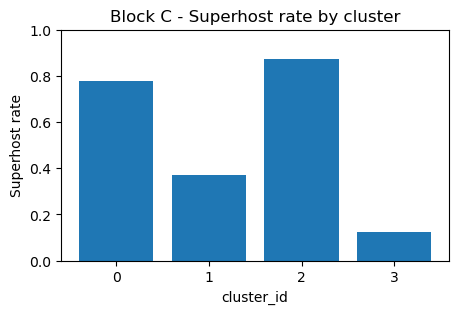

In [76]:
k_final = 4
kmeans = KMeans(n_clusters=k_final, n_init=20, random_state=42)

cluster_id = kmeans.fit_predict(XCs)   

tmp = XC.copy()                        
tmp["cluster_id"] = cluster_id
tmp["is_superhost"] = y.loc[tmp.index].astype(int).values

rate = (tmp.groupby("cluster_id")["is_superhost"]
          .agg(count="size", superhost_rate="mean")
          .sort_index())

display(rate)

plt.figure(figsize=(5,3))
plt.bar(rate.index.astype(str), rate["superhost_rate"].values)
plt.xlabel("cluster_id")
plt.ylabel("Superhost rate")
plt.title("Block C - Superhost rate by cluster")
plt.ylim(0, 1)
plt.show()

In [77]:
# X, y (Block C)
X = blocks["C_activity"]["X"].copy()
y = blocks["C_activity"]["y"].copy()

profile = (tmp.groupby("cluster_id")[blocks["C_activity"]["cols"]]
             .median()
             .round(3))
display(profile)

number_of_reviews  reviews_per_month  number_of_reviews_ltm  \
cluster_id                                                                
0                        98.0               2.88                   29.0   
1                        10.0               0.85                    3.0   
2                       297.0               6.29                   72.0   
3                         4.0               0.07                    0.0   

            number_of_reviews_l30d  days_since_last_review  
cluster_id                                                  
0                              1.0                    16.0  
1                              0.0                    81.0  
2                              4.0                     7.0  
3                              0.0                  1072.0

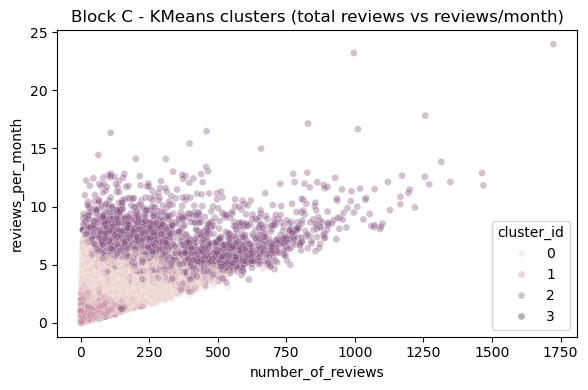

In [78]:
tmp = XC.copy()
tmp["cluster_id"] = cluster_id

plt.figure(figsize=(6,4))
sns.scatterplot(
    data=tmp,
    x="number_of_reviews",
    y="reviews_per_month",
    hue="cluster_id",
    alpha=0.35,
    s=25
)
plt.title("Block C - KMeans clusters (total reviews vs reviews/month)")
plt.tight_layout()
plt.show()

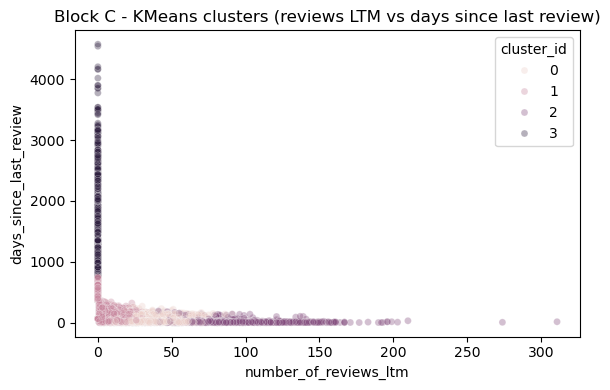

In [79]:
tmp = XC.copy()
tmp["cluster_id"] = cluster_id

plt.figure(figsize=(6,4))
sns.scatterplot(
    data=tmp,
    x="number_of_reviews_ltm",
    y="days_since_last_review",
    hue="cluster_id",
    alpha=0.35,
    s=25
)
plt.title("Block C - KMeans clusters (reviews LTM vs days since last review)")
plt.tight_layout()
plt.show()

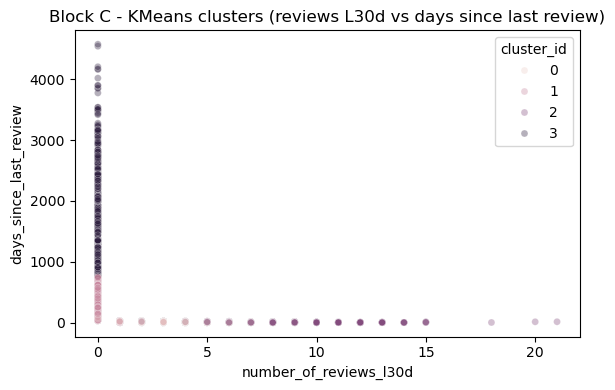

In [80]:
tmp = XC.copy()
tmp["cluster_id"] = cluster_id

plt.figure(figsize=(6,4))
sns.scatterplot(
    data=tmp,
    x="number_of_reviews_l30d",
    y="days_since_last_review",
    hue="cluster_id",
    alpha=0.35,
    s=25
)
plt.title("Block C - KMeans clusters (reviews L30d vs days since last review)")
plt.tight_layout()
plt.show()


### Block D property Structure (type/capacity/price/location)- Logistic regression

In [81]:
# X, y (Block D)
X = blocks["D_listing"]["X"].copy()
y = blocks["D_listing"]["y"].copy().astype(int)

if X.shape[1] == 0:
    raise ValueError("Block D has no listing columns. Check cols_D creation.")

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

for c in num_cols:
    X[c] = pd.to_numeric(X[c], errors="coerce")

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),

        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ],
    remainder="drop"
)

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=0, stratify=y
)

# model pipeline
clf = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=5000, class_weight="balanced"))
])

clf.fit(X_train, y_train)

test_prob = clf.predict_proba(X_test)[:, 1]
test_pred = (test_prob >= 0.5).astype(int)

train_prob = clf.predict_proba(X_train)[:, 1]
train_pred = (train_prob >= 0.5).astype(int)

def print_evaluate(y_true, y_prob, y_pred, name=""):
    auc = metrics.roc_auc_score(y_true, y_prob)
    ap  = metrics.average_precision_score(y_true, y_prob)  # PR-AUC
    acc = metrics.accuracy_score(y_true, y_pred)
    f1  = metrics.f1_score(y_true, y_pred)

    if name:
        print(name)

    print(f"AUC      : {auc:.4f}")
    print(f"PR-AUC   : {ap:.4f}")
    print(f"Accuracy : {acc:.4f}")
    print(f"F1       : {f1:.4f}")

    print("\nConfusion matrix:\n", metrics.confusion_matrix(y_true, y_pred))
    print("\nClassification report:\n", metrics.classification_report(y_true, y_pred, digits=4))

print_evaluate(y_test,  test_prob,  test_pred,  "Test set evaluation (Block D)")
print("\n" + "-"*40 + "\n")
print_evaluate(y_train, train_prob, train_pred, "Train set evaluation (Block D)")

Test set evaluation (Block D)
AUC      : 0.6951
PR-AUC   : 0.6616
Accuracy : 0.6442
F1       : 0.6339

Confusion matrix:
 [[4639 2531]
 [2378 4250]]

Classification report:
               precision    recall  f1-score   support

           0     0.6611    0.6470    0.6540      7170
           1     0.6268    0.6412    0.6339      6628

    accuracy                         0.6442     13798
   macro avg     0.6439    0.6441    0.6439     13798
weighted avg     0.6446    0.6442    0.6443     13798


----------------------------------------

Train set evaluation (Block D)
AUC      : 0.7299
PR-AUC   : 0.6991
Accuracy : 0.6671
F1       : 0.6568

Confusion matrix:
 [[11219  5511]
 [ 5207 10256]]

Classification report:
               precision    recall  f1-score   support

           0     0.6830    0.6706    0.6767     16730
           1     0.6505    0.6633    0.6568     15463

    accuracy                         0.6671     32193
   macro avg     0.6667    0.6669    0.6668     32193
weigh

In [84]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_auc = cross_val_score(clf, X, y, cv=cv, scoring="roc_auc",   n_jobs=1)
cv_acc = cross_val_score(clf, X, y, cv=cv, scoring="accuracy",  n_jobs=1)
cv_f1  = cross_val_score(clf, X, y, cv=cv, scoring="f1",        n_jobs=1)

print("CV AUC (5-fold):", cv_auc.mean(), "±", cv_auc.std())
print("CV ACC (5-fold):", cv_acc.mean(), "±", cv_acc.std())
print("CV F1  (5-fold):", cv_f1.mean(),  "±", cv_f1.std())

# Coefficients table
clf.fit(X, y)

#OneHot
feat_names = clf.named_steps["prep"].get_feature_names_out()

coef = clf.named_steps["clf"].coef_.ravel()

coef_df = (pd.DataFrame({"Feature": feat_names, "Coefficient": coef})
             .sort_values("Coefficient", ascending=False))

display(coef_df.head(30))   
display(coef_df.tail(30))   

CV AUC (5-fold): 0.6954472935890765 ± 0.00598761599221459
CV ACC (5-fold): 0.6423430172801382 ± 0.004360086443034432
CV F1  (5-fold): 0.6307231473526507 ± 0.006023345790823316


Feature  Coefficient
460        cat__neighbourhood_Auckland, Au, New Zealand     2.744610
1477  cat__neighbourhood_Onetangi, Waiheke, New Zealand     2.263266
990   cat__neighbourhood_Katikati, Bay Of Plenty, Ne...     1.954760
1312    cat__neighbourhood_Mount Maunganui, New Zealand     1.938811
263                    cat__region_name_Ruataniwha Ward     1.916833
1688  cat__neighbourhood_Pukenui, Northland, New Zea...     1.705135
1471   cat__neighbourhood_Oneroa, Auckland, New Zealand     1.694544
2125  cat__neighbourhood_Waiheke Island, Auckland, N...     1.657201
991   cat__neighbourhood_Katikati, Bay of Plenty, Ne...     1.651990
13                              cat__property_type_Dome     1.616280
2058   cat__neighbourhood_Tokaanu, Waikato, New Zealand     1.613088
83              cat__property_type_Private room in yurt     1.596430
1728     cat__neighbourhood_Queenstown, Ot, New Zealand     1.582479
77              cat__property_type_Private room in tipi     1.578877
1073  cat__neighbourhood_Lake Tarawera, Bay of Plent...     1.570911
894   cat__neighbourhood_Hot Water Beach, Waikato, N...     1.490371
2339          cat__neighbourhood_Whitianga, New Zealand     1.440923
1617             cat__neighbourhood_Picton, New Zealand     1.405884
2326  cat__neighbourhood_Whataroa, West Coast, New Z...     1.385559
2048  cat__neighbourhood_Timaru, Canterbury, New Zea...     1.373674
867     cat__neighbourhood_Hikuai, Waikato, New Zealand     1.373480
1856  cat__neighbourhood_Sherenden, Hawke's Bay, New...     1.362241
1937      cat__neighbourhood_Tarras, Otago, New Zealand     1.359524
1562  cat__neighbourhood_Palmerston North, Manawat??...     1.332906
2330  cat__neighbourhood_Whirinaki, Northland, New Z...     1.317410
1633  cat__neighbourhood_Pohuehue, Auckland, New Zea...     1.316665
638   cat__neighbourhood_Colville, Waikato, New Zealand     1.298189
53             cat__property_type_Private room in condo     1.294633
491   cat__neighbourhood_Banks Peninsula, South Isla...     1.290043
175                      cat__region_name_Hokitika Ward     1.287274

Feature  Coefficient
832   cat__neighbourhood_Haruru, Northland, New Zealand    -1.217566
767   cat__neighbourhood_Gisborne, Gisborne Region, ...    -1.219915
757   cat__neighbourhood_Garston, Southland, New Zea...    -1.251468
951   cat__neighbourhood_Kaimaumau, Northland, New Z...    -1.261446
2316  cat__neighbourhood_Whareama, Wellington, New Z...    -1.264657
1348  cat__neighbourhood_National Park, Manawat??-Wh...    -1.319383
2313  cat__neighbourhood_Whangaroa, Northland, New Z...    -1.333770
1575          cat__neighbourhood_Papatowai, New Zealand    -1.339942
1347  cat__neighbourhood_National Park Village, Tong...    -1.346712
1333  cat__neighbourhood_Murchison, Tasman, New Zealand    -1.368438
1418  cat__neighbourhood_Ohakune, Mt Ruapehu, New Ze...    -1.368444
2340  cat__neighbourhood_Whitianga, Waikato Region, ...    -1.382177
1675    cat__neighbourhood_Pukawa, Waikato, New Zealand    -1.385359
404   cat__neighbourhood_Amodeo Bay, Waikato, New Ze...    -1.403800
1951  cat__neighbourhood_Taup??, Waikato Region, New...    -1.407769
1137  cat__neighbourhood_Lumsden, Southland, New Zea...    -1.418807
1624  cat__neighbourhood_Pirinoa, Wellington, New Ze...    -1.455322
1454  cat__neighbourhood_Omapere, Northland, New Zea...    -1.464547
1958  cat__neighbourhood_Taupo Central, Lake Taupo, ...    -1.500843
10                          cat__property_type_Campsite    -1.519620
2147  cat__neighbourhood_Waikari, Canterbury, New Ze...    -1.520248
834   cat__neighbourhood_Hastings, Hawkes Bay, New Z...    -1.574117
313                       cat__region_name_Waipaoa Ward    -1.588091
1778  cat__neighbourhood_Richmond Downs, Waikato, Ne...    -1.602607
1023     cat__neighbourhood_Kinloch, Otago, New Zealand    -1.651223
1974  cat__neighbourhood_Te Anau, Southland Region, ...    -1.656872
1576   cat__neighbourhood_Papatowai, Otago, New Zealand    -1.813154
949   cat__neighbourhood_Kaikoura Flat, Canterbury, ...    -1.851481
90                    cat__property_type_Room in hostel    -2.087804
2260     cat__neighbourhood_West Coast, NZ, New Zealand    -2.183293

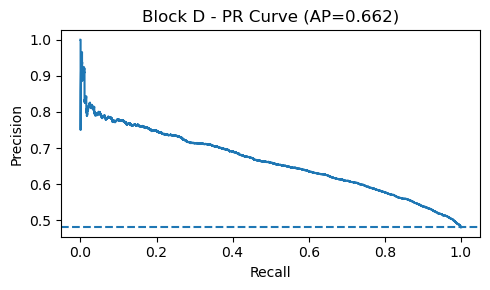

In [85]:
p, r, _ = precision_recall_curve(y_test, test_prob)
ap = average_precision_score(y_test, test_prob)

plt.figure(figsize=(5,3))
plt.plot(r, p)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Block D - PR Curve (AP={ap:.3f})")

plt.axhline(y_test.mean(), linestyle="--")
plt.tight_layout()
plt.show()

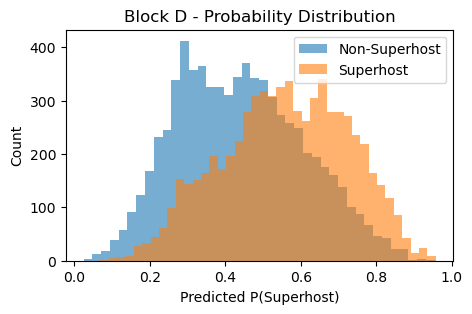

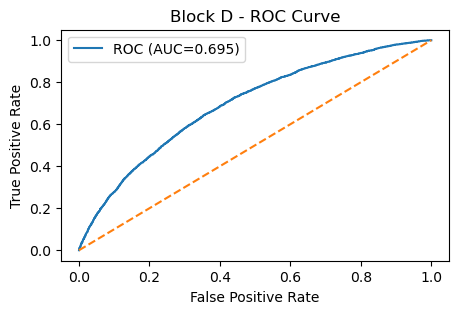

In [87]:
#Plots Probability distribution
plt.figure(figsize=(5,3))
plt.hist(test_prob[y_test == 0], bins=40, alpha=0.6, label="Non-Superhost")
plt.hist(test_prob[y_test == 1], bins=40, alpha=0.6, label="Superhost")
plt.xlabel("Predicted P(Superhost)")
plt.ylabel("Count")
plt.legend()
plt.title("Block D - Probability Distribution")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, test_prob)
auc = roc_auc_score(y_test, test_prob)

plt.figure(figsize=(5,3))
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Block D - ROC Curve")
plt.legend()
plt.show()

### Block D polynomial features with Logistic

In [89]:
# X, y (Block D)
X = blocks["D_listing"]["X"].copy()
y = blocks["D_listing"]["y"].copy().astype(int)

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

preprocess_poly = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("poly", PolynomialFeatures(degree=2, include_bias=False)),
            ("scaler", StandardScaler())
        ]), num_cols),

        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ],
    remainder="drop"
)

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)

# model
clf_poly = Pipeline([
    ("prep", preprocess_poly),
    ("clf", LogisticRegression(max_iter=8000, class_weight="balanced"))
])

clf_poly.fit(X_train, y_train)

prob = clf_poly.predict_proba(X_test)[:, 1]
pred = (prob >= 0.5).astype(int)

auc = metrics.roc_auc_score(y_test, prob)
ap  = metrics.average_precision_score(y_test, prob)
acc = metrics.accuracy_score(y_test, pred)
f1  = metrics.f1_score(y_test, pred)

print(f"AUC      : {auc:.4f}")
print(f"PR-AUC   : {ap:.4f}")
print(f"Accuracy : {acc:.4f}")
print(f"F1       : {f1:.4f}")
print("\nConfusion matrix:\n", metrics.confusion_matrix(y_test, pred))
print("\nClassification report:\n", metrics.classification_report(y_test, pred, digits=4))

AUC      : 0.6988
PR-AUC   : 0.6628
Accuracy : 0.6457
F1       : 0.6367

Confusion matrix:
 [[4626 2544]
 [2344 4284]]

Classification report:
               precision    recall  f1-score   support

           0     0.6637    0.6452    0.6543      7170
           1     0.6274    0.6463    0.6367      6628

    accuracy                         0.6457     13798
   macro avg     0.6456    0.6458    0.6455     13798
weighted avg     0.6463    0.6457    0.6459     13798



### Block D RandomForestClassifier

In [91]:
# X, y (Block D)
X = blocks["D_listing"]["X"].copy()
y = blocks["D_listing"]["y"].copy().astype(int)

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

preprocess_poly = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("poly", PolynomialFeatures(degree=2, include_bias=False)),
            ("scaler", StandardScaler())
        ]), num_cols),

        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ],
    remainder="drop"
)

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)

rf = Pipeline([("prep", preprocess),("clf", RandomForestClassifier(n_estimators=500,random_state=42,class_weight="balanced_subsample",n_jobs=1))])

rf.fit(X_train, y_train)

prob = rf.predict_proba(X_test)[:, 1]
pred = (prob >= 0.5).astype(int)

print("AUC      :", metrics.roc_auc_score(y_test, prob))
print("PR-AUC   :", metrics.average_precision_score(y_test, prob))
print("Accuracy :", metrics.accuracy_score(y_test, pred))
print("F1       :", metrics.f1_score(y_test, pred))
print("\nConfusion matrix:\n", metrics.confusion_matrix(y_test, pred))
print("\nClassification report:\n", metrics.classification_report(y_test, pred, digits=4))

feat_names = rf.named_steps["prep"].get_feature_names_out()
importances = rf.named_steps["clf"].feature_importances_

imp = (pd.Series(importances, index=feat_names)
         .sort_values(ascending=False))

display(imp.head(30))

AUC      : 0.7321701433165919
PR-AUC   : 0.704578838142947
Accuracy : 0.6658936077692419
F1       : 0.6537999399218984

Confusion matrix:
 [[4835 2335]
 [2275 4353]]

Classification report:
               precision    recall  f1-score   support

           0     0.6800    0.6743    0.6772      7170
           1     0.6509    0.6568    0.6538      6628

    accuracy                         0.6659     13798
   macro avg     0.6654    0.6655    0.6655     13798
weighted avg     0.6660    0.6659    0.6659     13798



num__log_price                                       0.236235
num__minimum_nights                                  0.063568
num__beds                                            0.061277
num__accommodates                                    0.059511
num__bathrooms_num                                   0.045807
num__bedrooms                                        0.038757
cat__neighbourhood_Auckland, New Zealand             0.017712
cat__property_type_Entire home                       0.011332
cat__region_name_Queenstown-Wakatipu Ward            0.010499
cat__property_type_Entire rental unit                0.008189
cat__region_name_Area Outside Ward                   0.007343
cat__region_name_Waitemat?? and Gulf Ward            0.006404
cat__room_type_Private room                          0.006197
cat__region_name_Wanaka Ward                         0.005740
cat__room_type_Entire home/apt                       0.005362
cat__property_type_Entire guest suite                0.005145
cat__pro

### Block D Gradient boost

In [94]:
# X, y (Block D)
X = blocks["D_listing"]["X"].copy()
y = blocks["D_listing"]["y"].copy().astype(int)

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=0, stratify=y
)

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

prep = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ],
    remainder="drop"
)

def run_gb_block_D(X_train, y_train, X_test, y_test, X_full, y_full,
                   model_name="GradientBoostingClassifier", params=None, cv=5, threshold=0.5):

    if params is None:
        params = {
            "n_estimators": 500,
            "max_depth": 3,
            "learning_rate": 0.05,
            "subsample": 0.8,
            "random_state": 42
        }

    gb_clf = Pipeline([
        ("prep", prep),
        ("clf", GradientBoostingClassifier(**params))
    ])

    gb_clf.fit(X_train, y_train)

    test_prob = gb_clf.predict_proba(X_test)[:, 1]
    test_pred = (test_prob >= threshold).astype(int)

    train_prob = gb_clf.predict_proba(X_train)[:, 1]
    train_pred = (train_prob >= threshold).astype(int)

    def scores(y_true, prob, pred):
        auc = metrics.roc_auc_score(y_true, prob)
        ap  = metrics.average_precision_score(y_true, prob)
        acc = metrics.accuracy_score(y_true, pred)
        f1  = metrics.f1_score(y_true, pred)
        return auc, ap, acc, f1

    # test metrics
    auc_t, ap_t, acc_t, f1_t = scores(y_test, test_prob, test_pred)

    # train metrics
    auc_tr, ap_tr, acc_tr, f1_tr = scores(y_train, train_prob, train_pred)

    print("Confusion matrix (test):")
    print(metrics.confusion_matrix(y_test, test_pred))
    print("\nClassification report (test):")
    print(metrics.classification_report(y_test, test_pred, digits=4))

    # CV AUC
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    cv_auc = cross_val_score(gb_clf, X_full, y_full, cv=skf, scoring="roc_auc", n_jobs=1)

    evaluate_df = pd.DataFrame(
        data=[[
            model_name,
            auc_t, ap_t, acc_t, f1_t,
            cv_auc
        ]],
        columns=["Model", "AUC", "PR-AUC", "Accuracy", "F1", "Cross Validation (AUC)"]
    )

    return gb_clf, evaluate_df

gb_model_D, evaluate_df_gb_D = run_gb_block_D(
    X_train, y_train, X_test, y_test,
    X, y,
    model_name="GradientBoostingClassifier (Block D)",
    cv=5,
    threshold=0.5
)

evaluate_df_gb_D

Confusion matrix (test):
[[5001 2169]
 [2551 4077]]

Classification report (test):
              precision    recall  f1-score   support

           0     0.6622    0.6975    0.6794      7170
           1     0.6527    0.6151    0.6334      6628

    accuracy                         0.6579     13798
   macro avg     0.6575    0.6563    0.6564     13798
weighted avg     0.6577    0.6579    0.6573     13798



Model       AUC    PR-AUC  Accuracy  \
0  GradientBoostingClassifier (Block D)  0.714013  0.684207  0.657921   

        F1                             Cross Validation (AUC)  
0  0.63337  [0.7144019359157536, 0.7233304085038196, 0.713...

In [98]:
feat_names = gb_model_D.named_steps["prep"].get_feature_names_out()
imp = pd.Series(gb_model_D.named_steps["clf"].feature_importances_,index=feat_names).sort_values(ascending=False)
display(imp.head(30))

num__log_price                                              0.159214
num__minimum_nights                                         0.097923
cat__neighbourhood_Auckland, New Zealand                    0.080854
cat__region_name_Queenstown-Wakatipu Ward                   0.077732
cat__property_type_Entire home                              0.058991
cat__room_type_Entire home/apt                              0.043741
cat__room_type_Private room                                 0.036512
num__bathrooms_num                                          0.031339
cat__property_type_Entire rental unit                       0.023622
cat__region_name_Wanaka Ward                                0.021485
cat__property_type_Entire bungalow                          0.019105
cat__region_name_Pukaki Ward                                0.017859
cat__region_name_Central Ward                               0.014504
num__accommodates                                           0.012980
num__beds                         

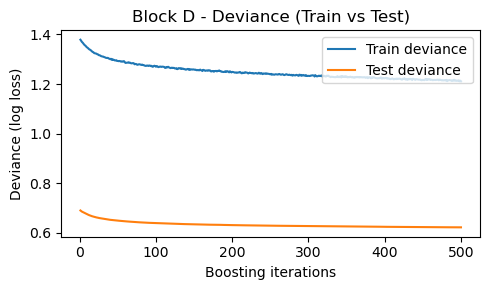

In [99]:
# X, y (Block D)
X = blocks["D_listing"]["X"].copy()
y = blocks["D_listing"]["y"].copy().astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)

prep  = gb_model_D.named_steps["prep"]
gb_clf = gb_model_D.named_steps["clf"]

Xtr = prep.transform(X_train)
Xte = prep.transform(X_test)

n_est = gb_clf.n_estimators
test_score = np.zeros(n_est, dtype=np.float64)

for i, proba in enumerate(gb_clf.staged_predict_proba(Xte)):
    test_score[i] = log_loss(y_test, proba, labels=gb_clf.classes_)

plt.figure(figsize=(5,3))
plt.title("Block D - Deviance (Train vs Test)")
plt.plot(np.arange(n_est) + 1, gb_clf.train_score_, label="Train deviance")
plt.plot(np.arange(n_est) + 1, test_score, label="Test deviance")
plt.xlabel("Boosting iterations")
plt.ylabel("Deviance (log loss)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

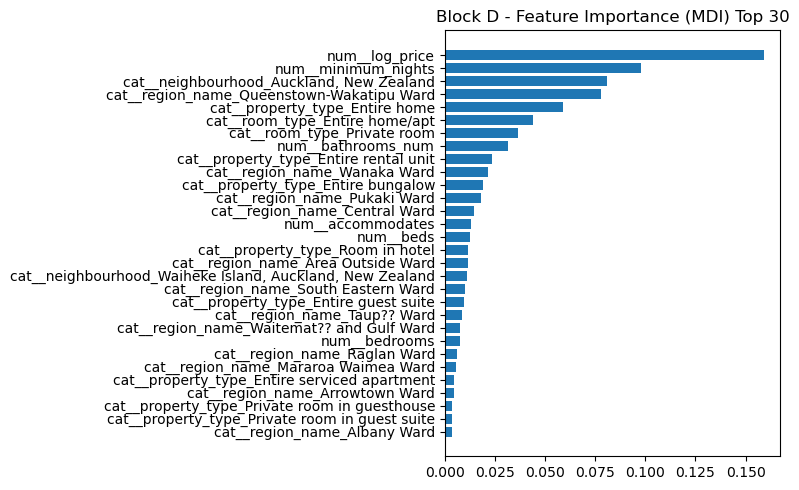

In [100]:
# X, y (Block D)
X = blocks["D_listing"]["X"].copy()
y = blocks["D_listing"]["y"].copy().astype(int)

gb_est = gb_model_D.named_steps["clf"]

feat_names = gb_model_D.named_steps["prep"].get_feature_names_out()
feature_importance = gb_est.feature_importances_

top_n = 30
idx = np.argsort(feature_importance)[-top_n:] 
pos = np.arange(top_n) + 0.5

plt.figure(figsize=(8, 5))
plt.barh(pos, feature_importance[idx], align="center")
plt.yticks(pos, np.array(feat_names)[idx])
plt.title(f"Block D - Feature Importance (MDI) Top {top_n}")
plt.tight_layout()
plt.show()

### Block D Decision tree

In [101]:
# X, y (Block D)
X = blocks["D_listing"]["X"].copy()
y = blocks["D_listing"]["y"].copy().astype(int)

if X.shape[1] == 0:
    raise ValueError("Block D has no listing columns. Check cols_D creation.")

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=15, stratify=y)

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# preprocess
prep = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore")),
        ]), cat_cols),
    ],
    remainder="drop"
)

# model pipeline
dtc = Pipeline([
    ("prep", prep),
    ("clf", DecisionTreeClassifier(
        max_depth=4,
        min_samples_leaf=200,
        class_weight="balanced",
        random_state=42
    ))
])

dtc.fit(X_train, y_train)

pred = dtc.predict(X_test)
prob = dtc.predict_proba(X_test)[:, 1]

print("Confusion matrix:\n", confusion_matrix(y_test, pred))
print("\nClassification report:\n", classification_report(y_test, pred, digits=4))

print("\nAUC   :", roc_auc_score(y_test, prob))
print("PR-AUC:", average_precision_score(y_test, prob))
print("Acc   :", accuracy_score(y_test, pred))
print("F1    :", f1_score(y_test, pred))

Confusion matrix:
 [[4493 2677]
 [2697 3931]]

Classification report:
               precision    recall  f1-score   support

           0     0.6249    0.6266    0.6258      7170
           1     0.5949    0.5931    0.5940      6628

    accuracy                         0.6105     13798
   macro avg     0.6099    0.6099    0.6099     13798
weighted avg     0.6105    0.6105    0.6105     13798


AUC   : 0.6493593175143868
PR-AUC: 0.6026789051826904
Acc   : 0.6105232642411944
F1    : 0.59398609851919


In [106]:
dtc_pipe = Pipeline([("prep", preprocess), ("clf", DecisionTreeClassifier(random_state=42))])
dtc_pipe.fit(X_train, y_train)

prob = dtc_pipe.predict_proba(X_test)[:, 1]
pred = (prob >= 0.5).astype(int)

print_evaluate(y_test, prob, pred, name="DecisionTree (test) - Block D (pipeline)")

DecisionTree (test) - Block D (pipeline)
AUC      : 0.6246
PR-AUC   : 0.5597
Accuracy : 0.6239
F1       : 0.6132

Confusion matrix:
 [[4496 2674]
 [2515 4113]]

Classification report:
               precision    recall  f1-score   support

           0     0.6413    0.6271    0.6341      7170
           1     0.6060    0.6205    0.6132      6628

    accuracy                         0.6239     13798
   macro avg     0.6236    0.6238    0.6236     13798
weighted avg     0.6243    0.6239    0.6241     13798



In [107]:
feat_names = dtc_pipe.named_steps["prep"].get_feature_names_out()
imp = pd.Series(dtc_pipe.named_steps["clf"].feature_importances_, index=feat_names)\
        .sort_values(ascending=False)

display(imp.head(30))

num__log_price                                    0.246853
num__beds                                         0.053880
num__accommodates                                 0.052550
num__minimum_nights                               0.050821
num__bathrooms_num                                0.042574
num__bedrooms                                     0.036574
cat__region_name_Queenstown-Wakatipu Ward         0.017513
cat__neighbourhood_Auckland, New Zealand          0.016674
cat__property_type_Entire home                    0.011123
cat__property_type_Entire rental unit             0.010848
cat__region_name_Area Outside Ward                0.010668
cat__room_type_Private room                       0.008199
cat__region_name_Wanaka Ward                      0.008190
cat__region_name_Waitemat?? and Gulf Ward         0.006574
cat__property_type_Entire guesthouse              0.005918
cat__region_name_Albany Ward                      0.005901
cat__region_name_Taup?? Ward                      0.0057

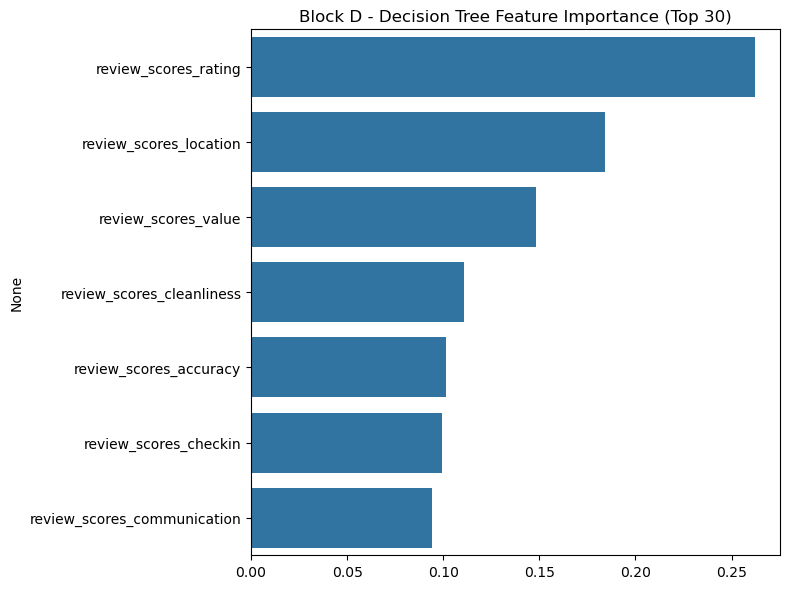

In [108]:
plt.figure(figsize=(8,6))
sns.barplot(x=importance.head(30).values, y=importance.head(30).index)
plt.title("Block D - Decision Tree Feature Importance (Top 30)")
plt.tight_layout()
plt.show()

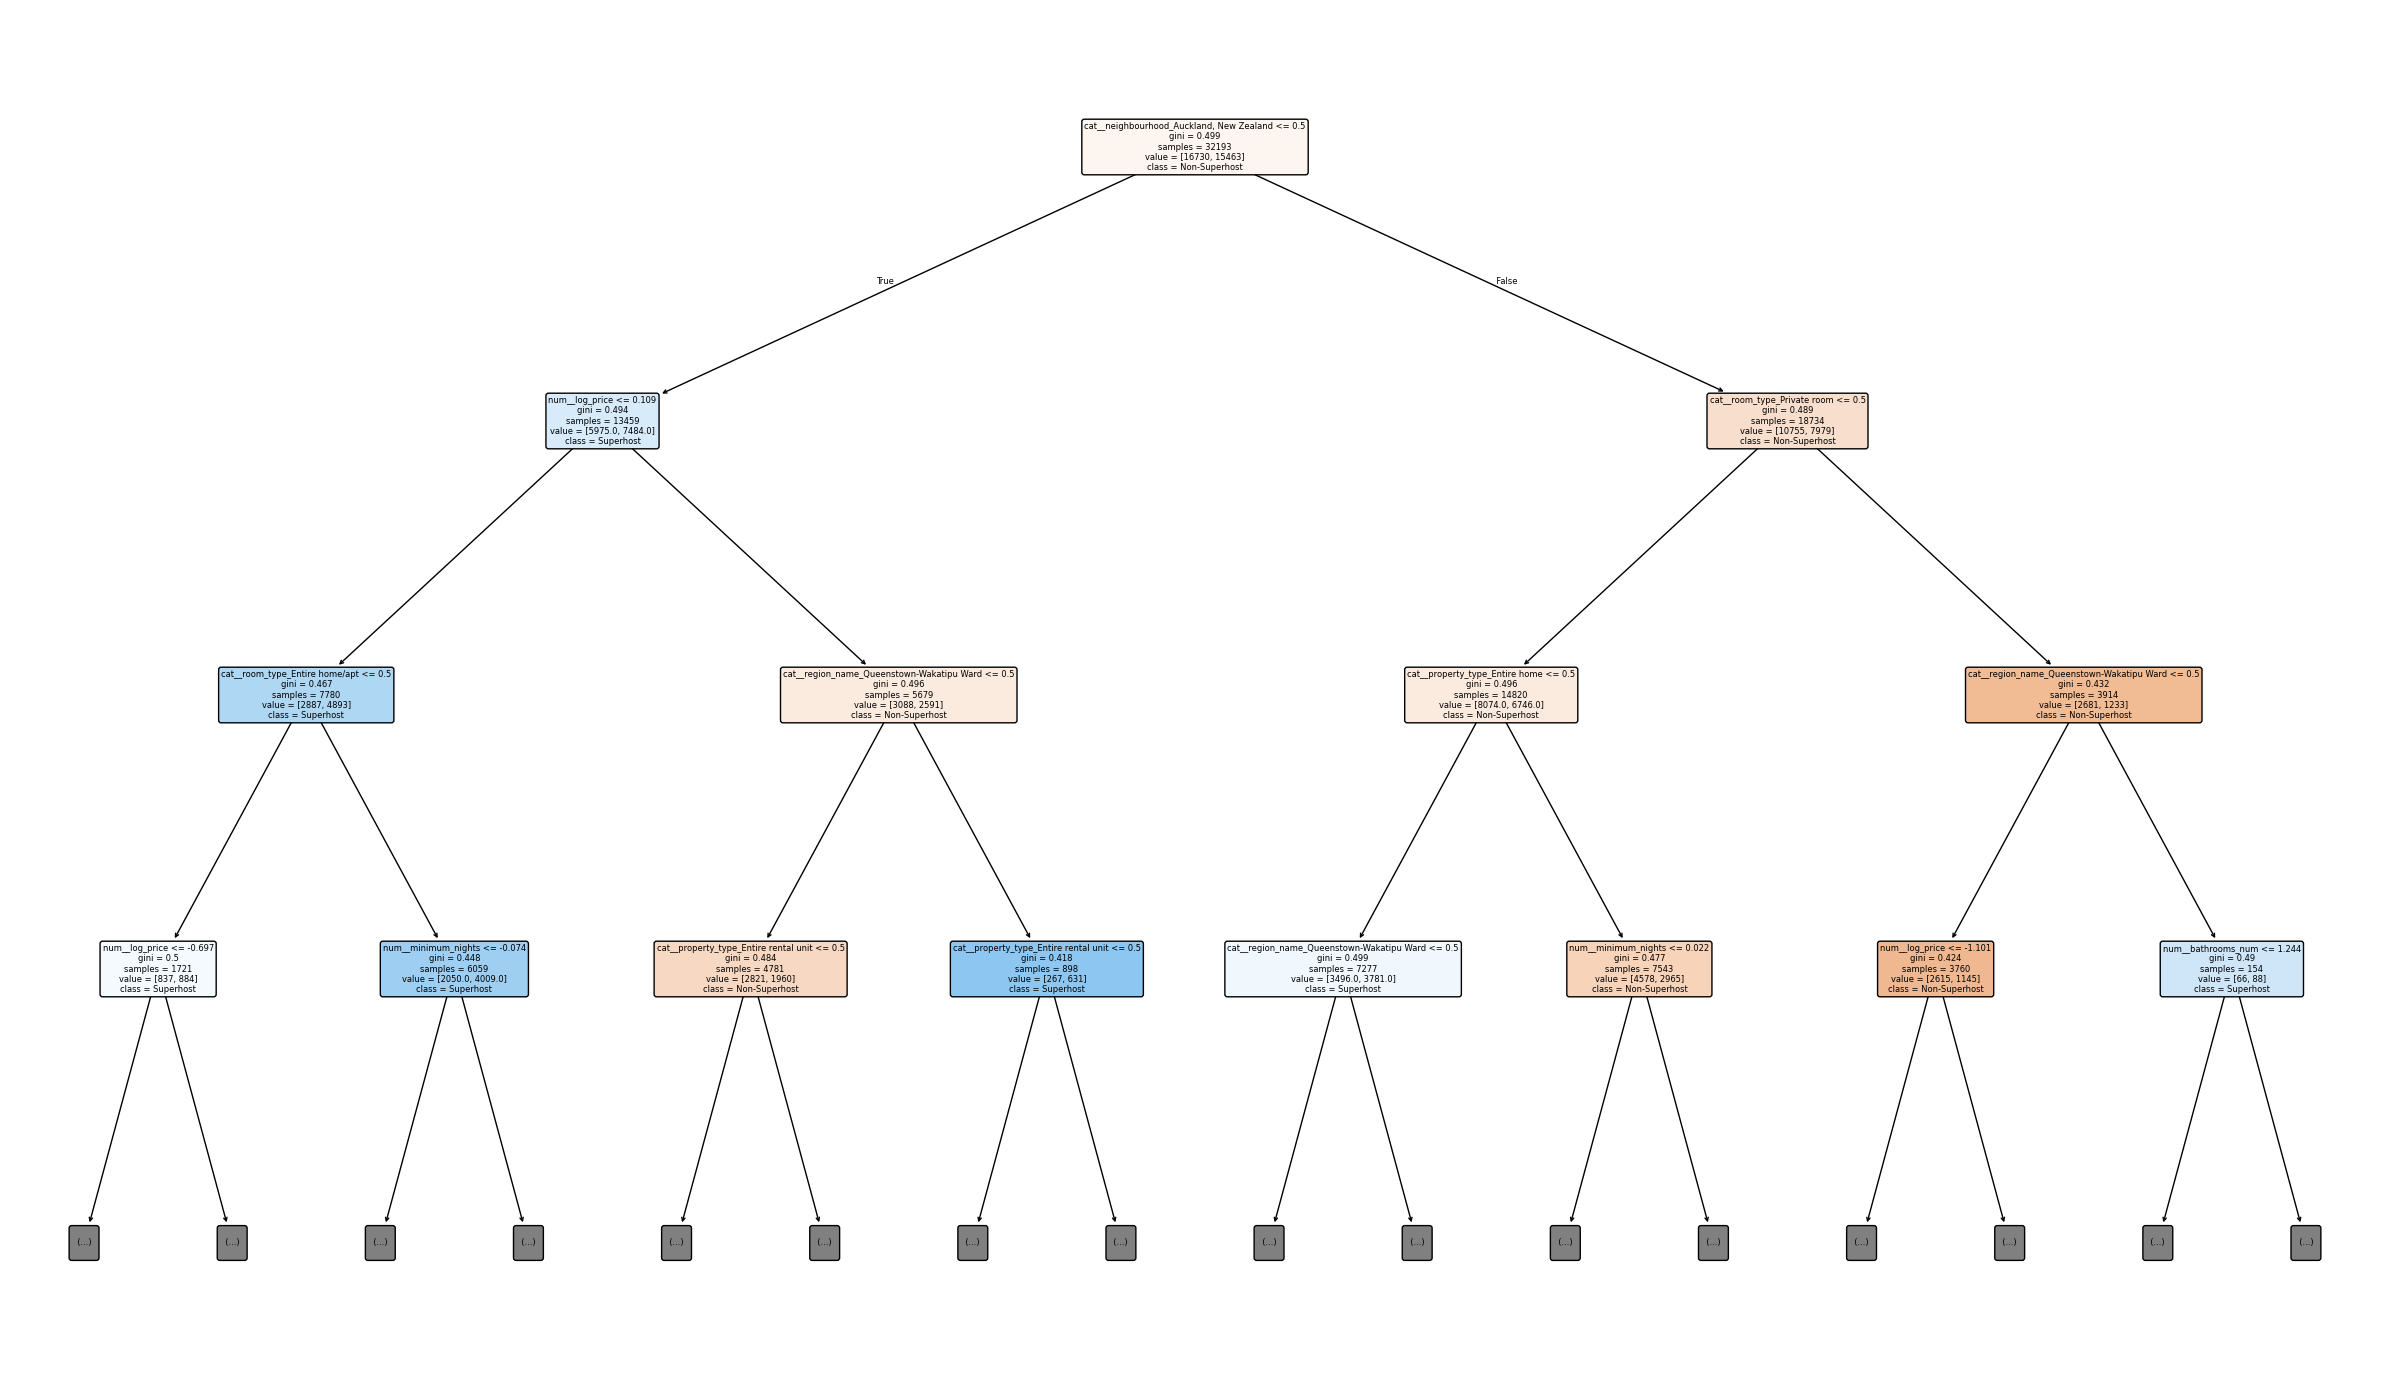

In [112]:
clf_tree   = dtc_pipe.named_steps["clf"]   
feat_names = dtc_pipe.named_steps["prep"].get_feature_names_out() 

plt.figure(figsize=(24, 14))
sktree.plot_tree(clf_tree,feature_names=feat_names,class_names=["Non-Superhost", "Superhost"],filled=True,rounded=True,max_depth=3,fontsize=6)
plt.tight_layout()
plt.show()

[Text(0.5146153461987875, 0.9957983193277311, 'x[422] <= 0.5\ngini = 0.499\nsamples = 32193\nvalue = [16730, 15463]'),
 Text(0.19129066904890438, 0.9873949579831933, 'x[5] <= 0.109\ngini = 0.494\nsamples = 13459\nvalue = [5975.0, 7484.0]'),
 Text(0.3529530076238459, 0.9915966386554622, 'True  '),
 Text(0.0822305850886827, 0.9789915966386554, 'x[109] <= 0.5\ngini = 0.467\nsamples = 7780\nvalue = [2887, 4893]'),
 Text(0.05027323391781828, 0.9705882352941176, 'x[5] <= -0.697\ngini = 0.5\nsamples = 1721\nvalue = [837, 884]'),
 Text(0.04169906705649729, 0.9621848739495799, 'x[4] <= 0.119\ngini = 0.484\nsamples = 1018\nvalue = [418, 600]'),
 Text(0.03738422952507723, 0.9537815126050421, 'x[5] <= -1.176\ngini = 0.48\nsamples = 988\nvalue = [394, 594]'),
 Text(0.03266276720762687, 0.9453781512605042, 'x[116] <= 0.5\ngini = 0.455\nsamples = 572\nvalue = [200, 372]'),
 Text(0.031882604877256096, 0.9369747899159664, 'x[268] <= 0.5\ngini = 0.449\nsamples = 560\nvalue = [191, 369]'),
 Text(0.031436

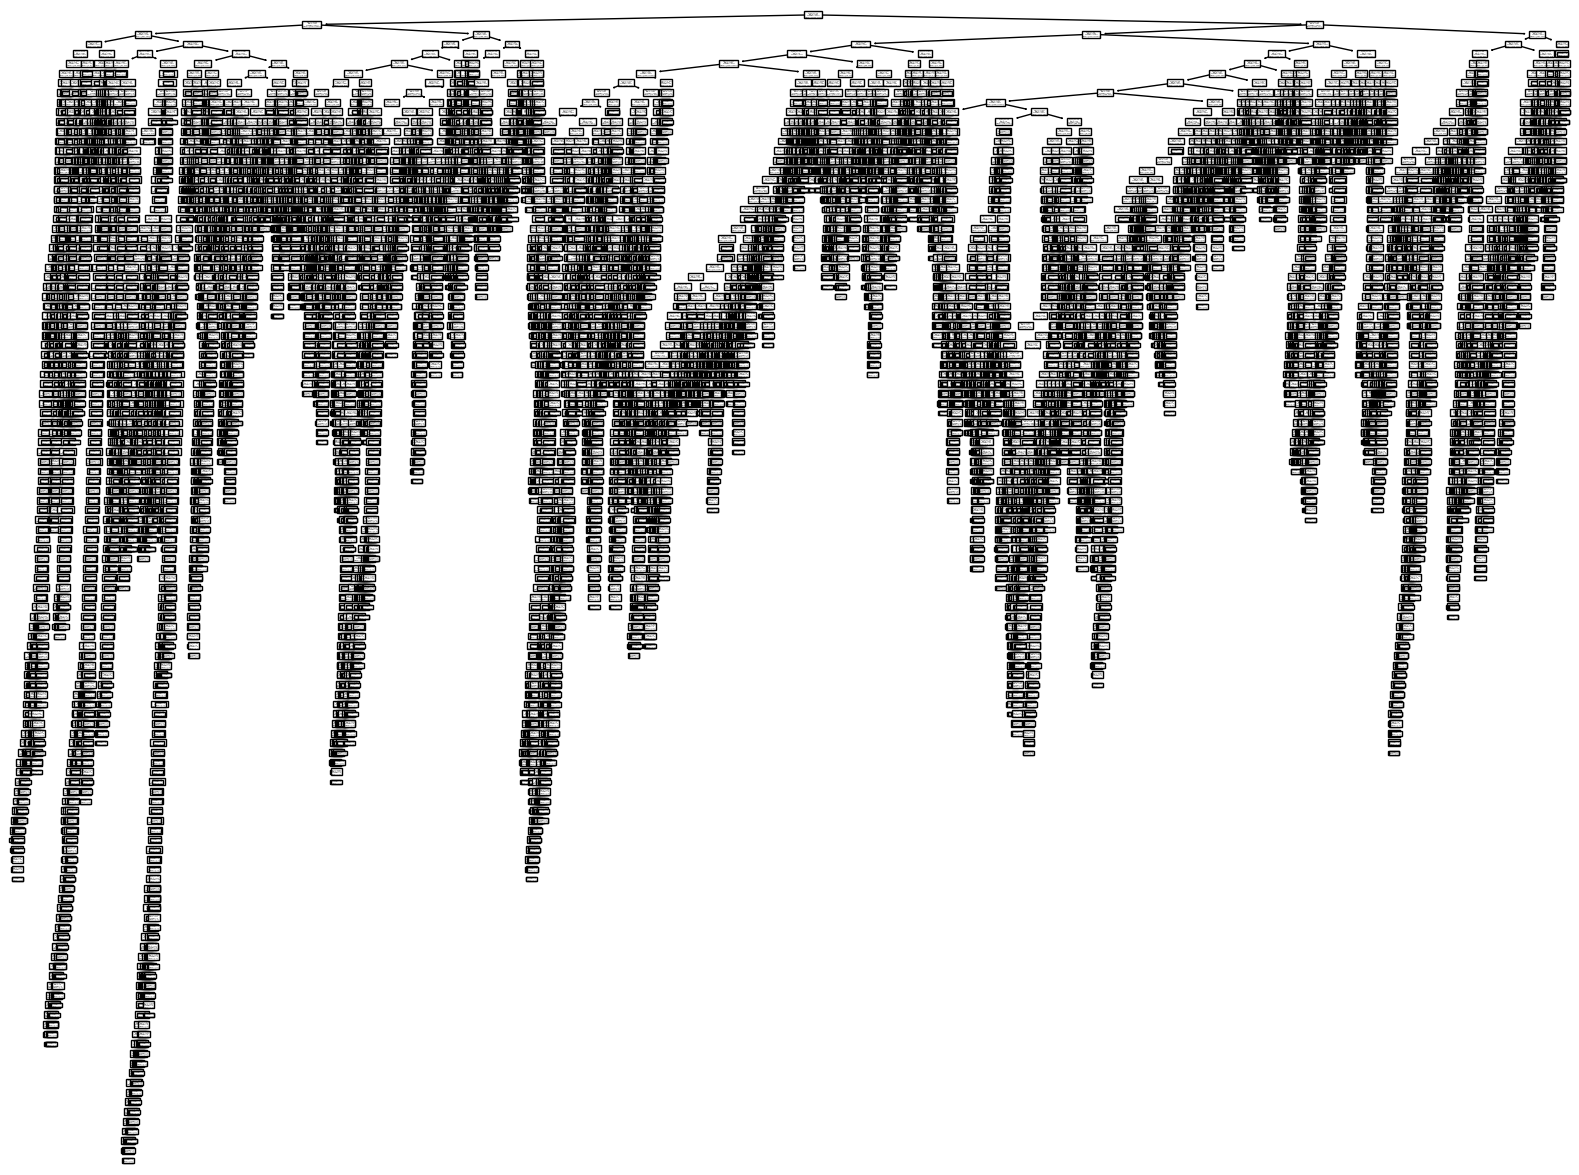

In [117]:
plt.rcParams["figure.figsize"] = (20, 15)
tree.plot_tree(dtc)

### Block D K-means

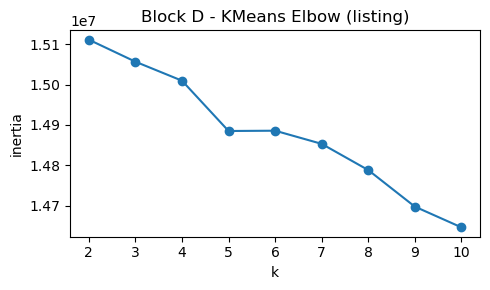

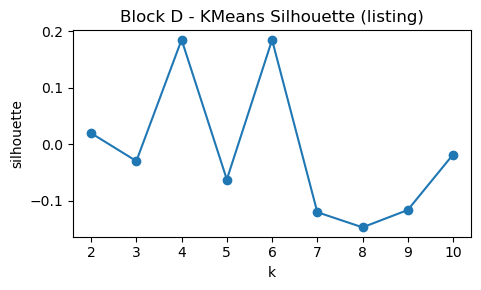

In [118]:
X = blocks["D_listing"]["X"].copy()
X = X.drop(columns=["neighbourhood"], errors="ignore")

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# preprocess
prep = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),

        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ],
    remainder="drop")

Xd = prep.fit_transform(X)
Xd = StandardScaler(with_mean=False).fit_transform(Xd)

# Elbow + Silhouette
Ks = range(2, 11)
inertias, sils = [], []

for k in Ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(Xd)
    inertias.append(km.inertia_)

    sils.append(silhouette_score(Xd, labels, sample_size=2000, random_state=42))

plt.figure(figsize=(5,3))
plt.plot(list(Ks), inertias, marker="o")
plt.xlabel("k"); plt.ylabel("inertia")
plt.title("Block D - KMeans Elbow (listing)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(list(Ks), sils, marker="o")
plt.xlabel("k"); plt.ylabel("silhouette")
plt.title("Block D - KMeans Silhouette (listing)")
plt.tight_layout()
plt.show()

count  superhost_rate
cluster_id                       
0           16761        0.465903
1            6926        0.420300
2           22284        0.510007
3              20        0.300000

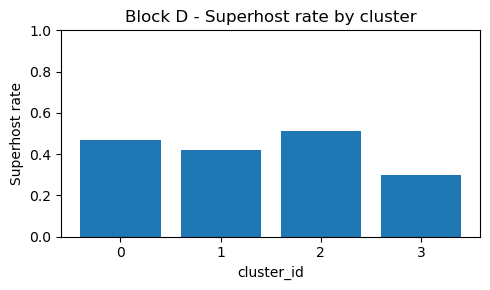

In [127]:
X = blocks["D_listing"]["X"].copy()
y = blocks["D_listing"]["y"].copy().astype(int)

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

prep = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ],
    remainder="drop"
)

XD = prep.fit_transform(X)

#KMeans + cluster_id
k_final = 4
kmeans = KMeans(n_clusters=k_final, n_init=20, random_state=42)
cluster_id = kmeans.fit_predict(XD)


tmp = X.copy()
tmp["cluster_id"] = cluster_id
tmp["is_superhost"] = y.loc[tmp.index].values  # y已经是int了

rate = (tmp.groupby("cluster_id")["is_superhost"]
        .agg(count="size", superhost_rate="mean")
        .sort_index())

display(rate)

plt.figure(figsize=(5,3))
plt.bar(rate.index.astype(str), rate["superhost_rate"].values)
plt.xlabel("cluster_id")
plt.ylabel("Superhost rate")
plt.title("Block D - Superhost rate by cluster")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [128]:
X = blocks["D_listing"]["X"].copy()

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c in tmp.columns]

profile_num = tmp.groupby("cluster_id")[num_cols].median().round(3)
display(profile_num)

cat_cols = [c for c in X.columns if c not in num_cols]
cat_cols = [c for c in cat_cols if c in tmp.columns]

profile_cat = tmp.groupby("cluster_id")[cat_cols].agg(
    lambda s: s.astype(str).mode().iat[0] if not s.mode().empty else np.nan
)
display(profile_cat)

accommodates  bedrooms  beds  bathrooms_num  minimum_nights  \
cluster_id                                                                
0                    6.0       3.0   3.0            1.5             2.0   
1                    8.0       4.0   6.0            2.5             2.0   
2                    2.0       1.0   1.0            1.0             1.0   
3                    2.0       1.0   1.0            1.0           365.0   

            log_price  
cluster_id             
0               5.545  
1               6.188  
2               4.844  
3               4.811

property_type        room_type               region_name  \
cluster_id                                                                    
0                    Entire home  Entire home/apt  Queenstown-Wakatipu Ward   
1                    Entire home  Entire home/apt  Queenstown-Wakatipu Ward   
2           Private room in home  Entire home/apt         Area Outside Ward   
3           Private room in home  Entire home/apt               Albany Ward   

           neighbourhood  
cluster_id                
0                    nan  
1                    nan  
2                    nan  
3                    nan

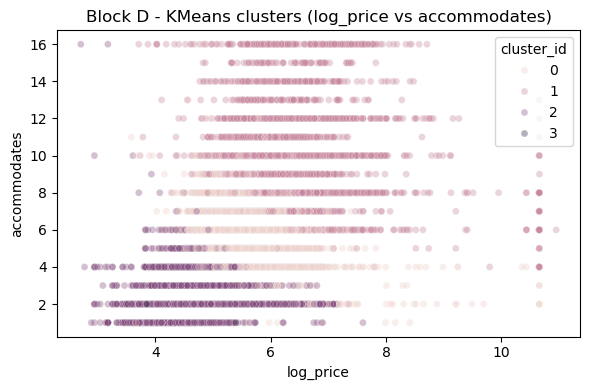

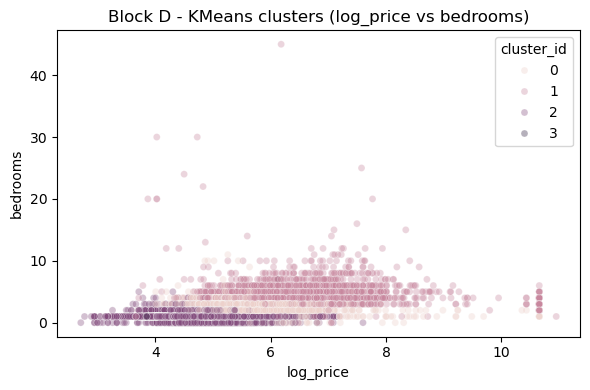

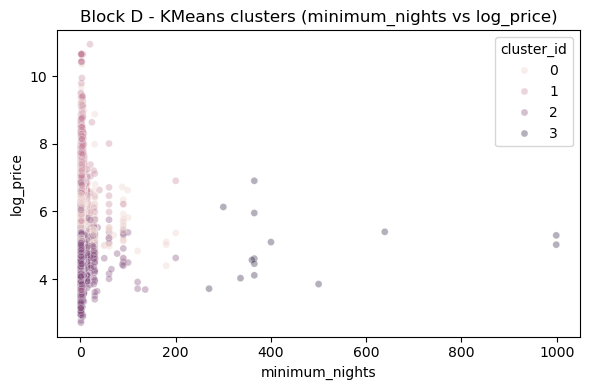

In [130]:
pairs = [
    ("log_price", "accommodates"),
    ("log_price", "bedrooms"),
    ("minimum_nights", "log_price"),
]

for x_col, y_col in pairs:
    plt.figure(figsize=(6,4))
    sns.scatterplot(
        data=tmp,
        x=x_col,
        y=y_col,
        hue="cluster_id",
        alpha=0.35,
        s=25
    )
    plt.title(f"Block D - KMeans clusters ({x_col} vs {y_col})")
    plt.tight_layout()
    plt.show()